In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import seaborn as sn
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
import lifelines
import models
import torch
from pycox.models import DeepHitSingle
import warnings
import utils

import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from ray import tune

pd.set_option('display.max_columns', None)


In [3]:
df = utils.get_unprocessed_metabric()[0]
df

Study ID Patient ID  Sample ID  Age at Diagnosis  \
0     brca_metabric    MB-0000    MB-0000             75.65   
1     brca_metabric    MB-0002    MB-0002             43.19   
2     brca_metabric    MB-0005    MB-0005             48.87   
3     brca_metabric    MB-0006    MB-0006             47.68   
4     brca_metabric    MB-0008    MB-0008             76.97   
...             ...        ...        ...               ...   
2504  brca_metabric  MTS-T2428  MTS-T2428             70.05   
2505  brca_metabric  MTS-T2429  MTS-T2429             63.60   
2506  brca_metabric  MTS-T2430  MTS-T2430               NaN   
2507  brca_metabric  MTS-T2431  MTS-T2431               NaN   
2508  brca_metabric  MTS-T2432  MTS-T2432               NaN   

     Type of Breast Surgery    Cancer Type  \
0                MASTECTOMY  Breast Cancer   
1         BREAST CONSERVING  Breast Cancer   
2                MASTECTOMY  Breast Cancer   
3                MASTECTOMY  Breast Cancer   
4                MASTECTOMY  Breast Cancer   
...                     ...            ...   
2504                    NaN  Breast Cancer   
2505                    NaN  Breast Cancer   
2506                    NaN  Breast Cancer   
2507                    NaN  Breast Cancer   
2508                    NaN  Breast Cancer   

                           Cancer Type Detailed Cellularity Chemotherapy  \
0              Breast Invasive Ductal Carcinoma         NaN           NO   
1              Breast Invasive Ductal Carcinoma        High           NO   
2              Breast Invasive Ductal Carcinoma        High          YES   
3     Breast Mixed Ductal and Lobular Carcinoma    Moderate          YES   
4     Breast Mixed Ductal and Lobular Carcinoma        High          YES   
...                                         ...         ...          ...   
2504                  Invasive Breast Carcinoma         NaN          NaN   
2505                  Invasive Breast Carcinoma         NaN          NaN   
2506                  Invasive Breast Carcinoma         NaN          NaN   
2507                  Invasive Breast Carcinoma         NaN          NaN   
2508                  Invasive Breast Carcinoma         NaN          NaN   

     Pam50 + Claudin-low subtype  Cohort ER status measured by IHC ER Status  \
0                    claudin-low     1.0                   Positve  Positive   
1                           LumA     1.0                   Positve  Positive   
2                           LumB     1.0                   Positve  Positive   
3                           LumB     1.0                   Positve  Positive   
4                           LumB     1.0                   Positve  Positive   
...                          ...     ...                       ...       ...   
2504                         NaN     1.0                   Positve  Positive   
2505                         NaN     1.0                   Positve  Positive   
2506                         NaN     NaN                       NaN       NaN   
2507                         NaN     NaN                       NaN       NaN   
2508                         NaN     NaN                       NaN       NaN   

      Neoplasm Histologic Grade HER2 status measured by SNP6 HER2 Status  \
0                           3.0                      NEUTRAL    Negative   
1                           3.0                      NEUTRAL    Negative   
2                           2.0                      NEUTRAL    Negative   
3                           2.0                      NEUTRAL    Negative   
4                           3.0                      NEUTRAL    Negative   
...                         ...                          ...         ...   
2504                        1.0                          NaN         NaN   
2505                        2.0                          NaN         NaN   
2506                        NaN                          NaN         NaN   
2507                        NaN                          NaN       

## Test set

In [4]:
df_clear, event_col, duration_col = utils.get_metabric(missing_values_strategy="mean")
df_train, df_test = utils.split_dataset(df_clear)
df_train


Age at Diagnosis  Cohort  Lymph nodes examined positive  \
1779             45.30     4.0                      13.000000   
2279             51.00     7.0                       1.950513   
406              39.30     1.0                       5.000000   
1650             70.90     5.0                       0.000000   
1653             71.74     5.0                       0.000000   
...                ...     ...                            ...   
1638             76.99     5.0                      15.000000   
1095             64.30     3.0                       1.000000   
1130             72.54     3.0                       5.000000   
1294             61.28     3.0                       0.000000   
860              74.32     3.0                       3.000000   

      Nottingham prognostic index  Overall Survival (Months)  Tumor Size  \
1779                     6.100000                  32.066667   50.000000   
2279                     4.028787                 125.244271   26.220093   
406                      6.046000                  48.600000   23.000000   
1650                     2.052000                  74.933333   26.000000   
1653                     3.050000                 195.300000   25.000000   
...                           ...                        ...         ...   
1638                     6.030000                 115.633333   15.000000   
1095                     5.000000                 129.233333   26.220093   
1130                     6.044000                 216.733333   22.000000   
1294                     3.050000                  16.566667   25.000000   
860                      4.040000                  59.933333   20.000000   

      Tumor Stage  Event  Type of Breast Surgery_MASTECTOMY  Cellularity_Low  \
1779     1.713647   True                                  1                0   
2279     1.713647   True                                  0                0   
406      2.000000   True                                  1                0   
1650     1.713647   True                                  1                0   
1653     1.713647  False                                  1                0   
...           ...    ...                                ...              ...   
1638     1.713647   True                                  1                0   
1095     3.000000   True                                  0                0   
1130     1.713647   True                                  0                0   
1294     2.000000   True                                  1                0   
860      2.000000   True                                  1                0   

      Cellularity_Moderate  Chemotherapy_YES  \
1779                     1                 1   
2279                     0                 0   
406                      1                 1   
1650                     0                 0   
1653                     1                 0   
...                    ...               ...   
1638                     0                 0   
1095                     1                 1   
1130                     1                 0   
1294                     1                 0   
860                      0                 0   

      Pam50 + Claudin-low subtype_Basal  Pam50 + Claudin-low subtype_Her2  \
1779                                  0                                 1   
2279                                  0                                 0   
406                                   0                                 0   
1650                                  0                                 0   
1653                                  0                                 0   
...                                 ...                               ...   
1638                                  0                                 0   
1095                                  0                                 0   
1130                                  0                                 0   
1294

<AxesSubplot: >

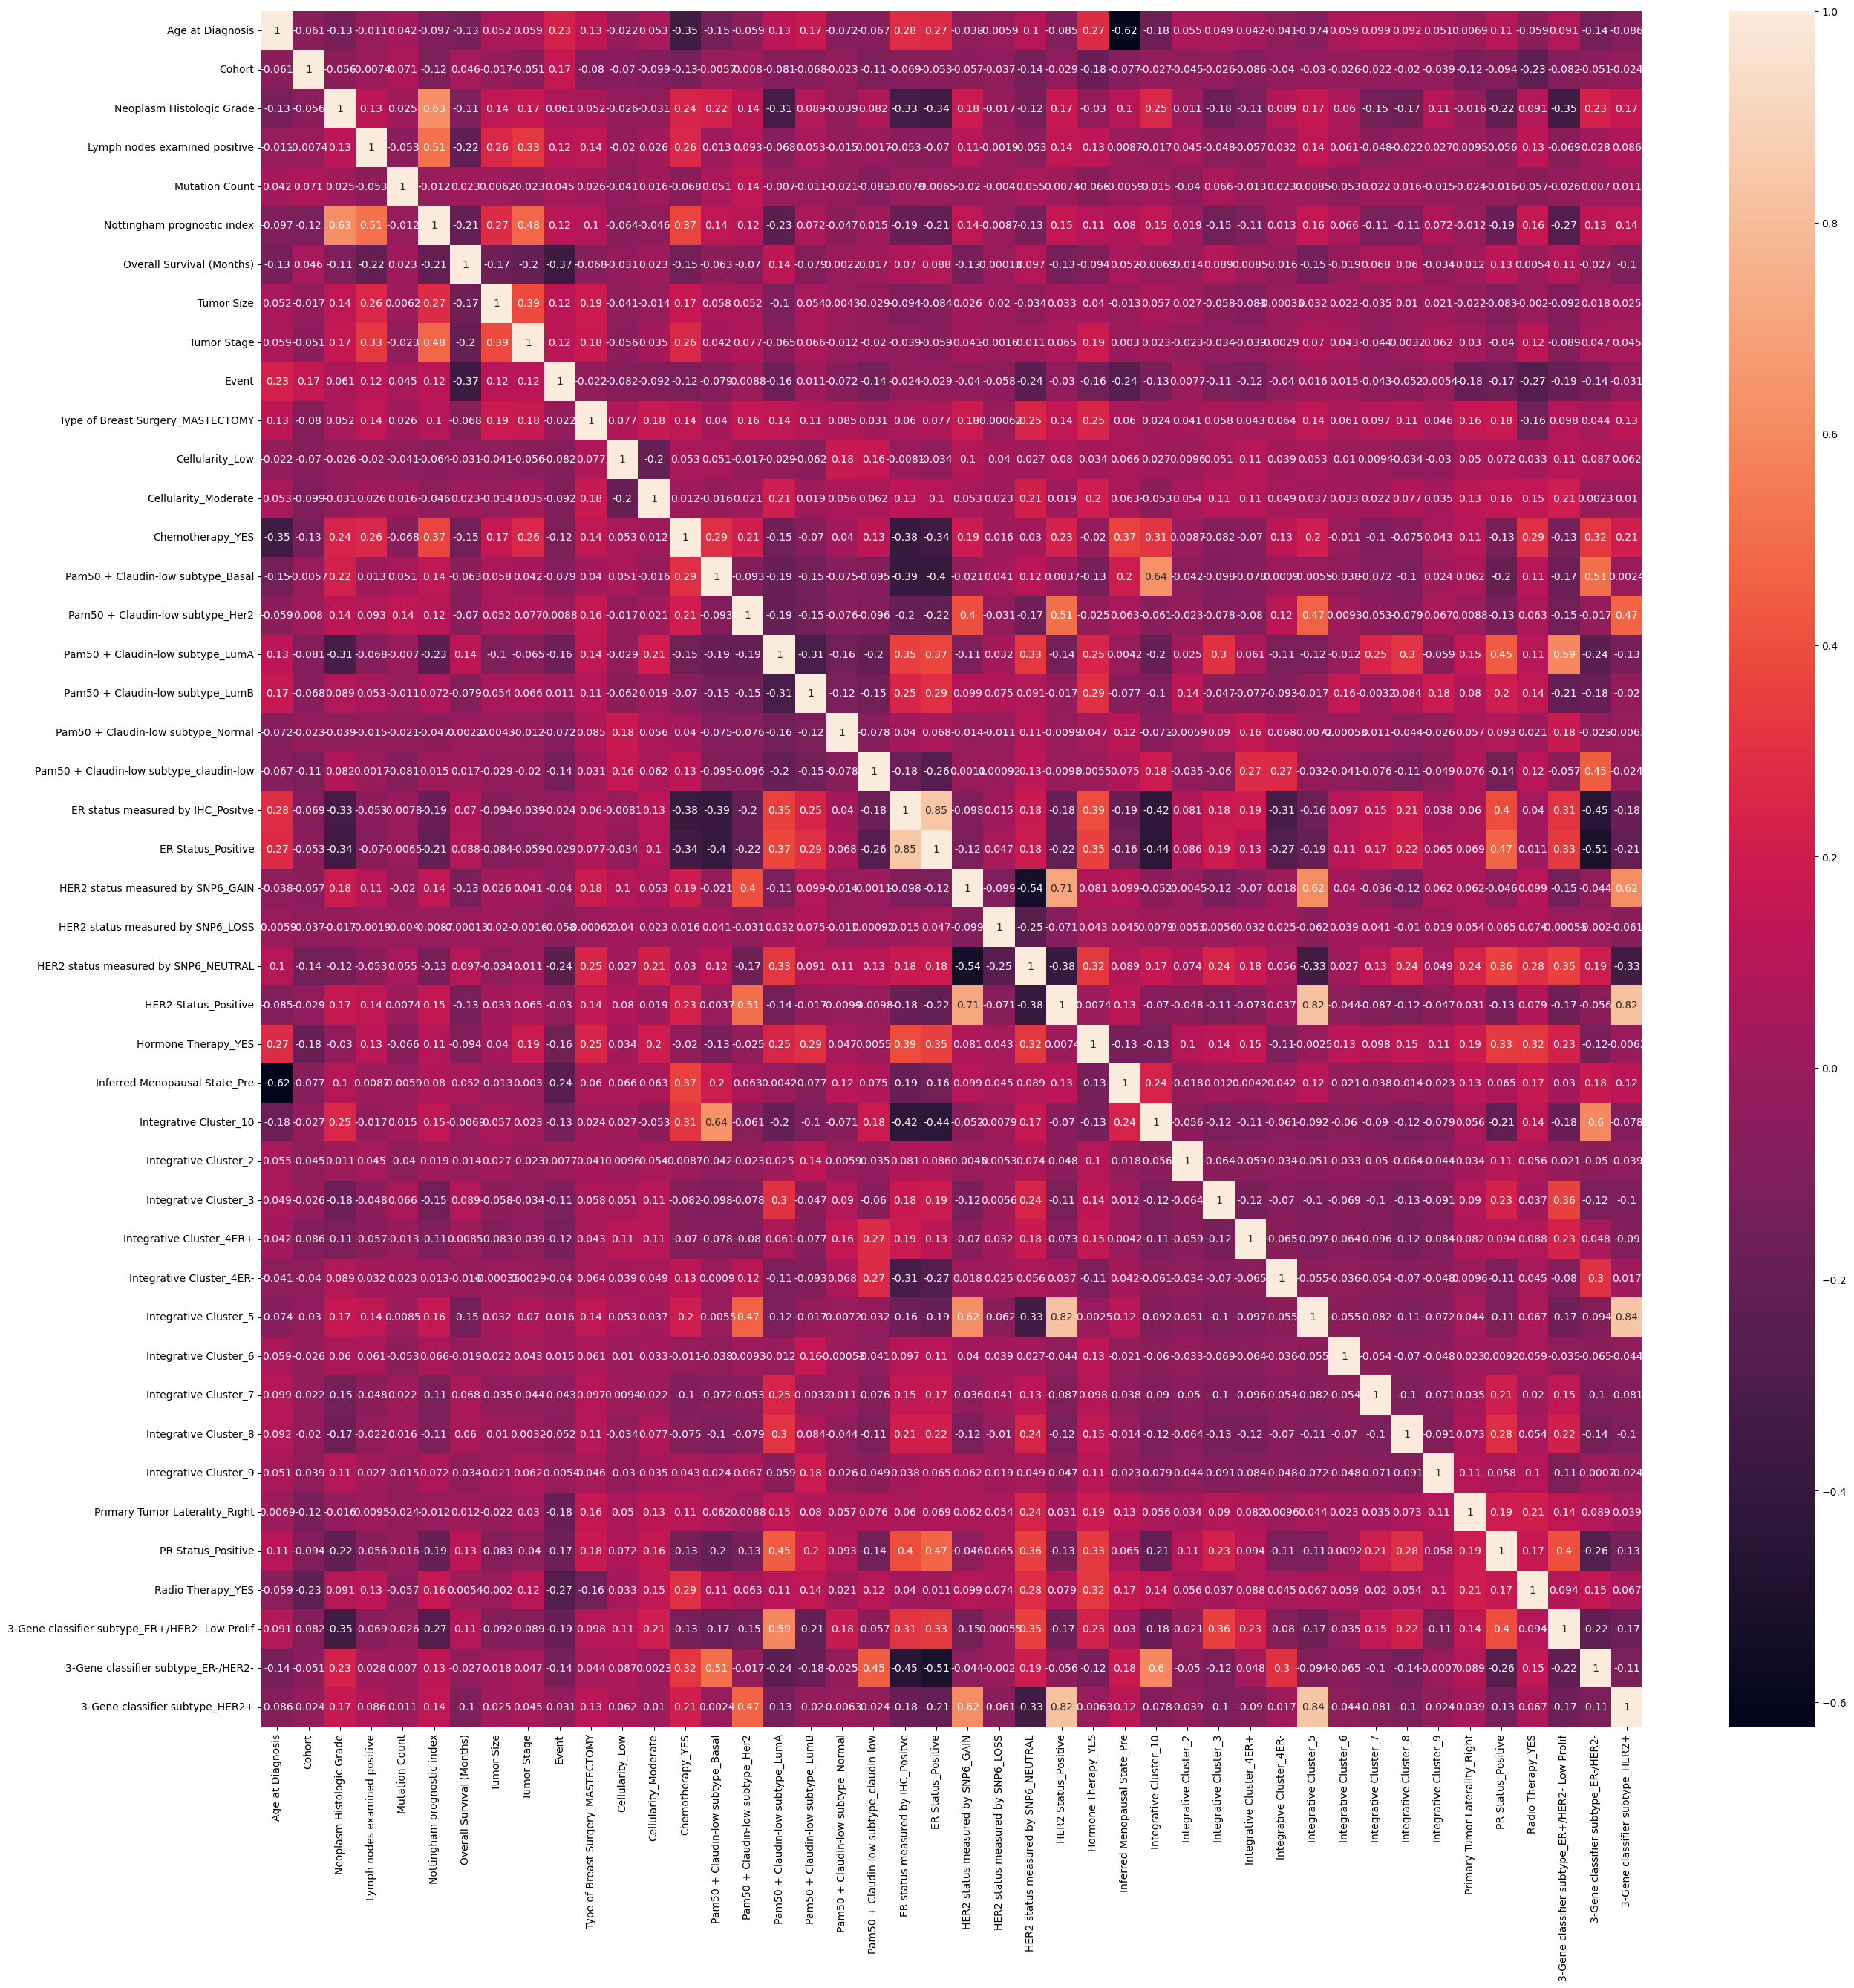

In [10]:
plt.figure(figsize=(30, 30))
sn.heatmap(df_train.corr(), annot=True)

In [14]:
X = df_train.drop([event_col, duration_col], axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_3012\1916246099.py", line 6, in <module>
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_3012\1916246099.py", line 6, in <listcomp>
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\statsmodels\stats\outliers_influence.py", line 194, in variance_inflation_factor
    r_squared_i = OLS(x_i, x_noti).fit().rsquared
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\statsmodels\regression\linear_model.py", line 890, in __init__
    super(OLS, self).__init__(endog, exog, missing=missing,
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\statsmodels\regr

In [25]:
df_clear, event_col, duration_col = utils.get_metabric(missing_values_strategy="mean")
df_train, df_test = utils.split_dataset(df_clear)
df_train

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)
mean_concordance = 0.0
models = []
oof_preds = np.zeros((len(df_train), 1))
df_train_copy = df_train.copy()

for i, (train_index, test_index) in enumerate(kf.split(df_train_copy)):

    train = df_train_copy.iloc[train_index]
    valid = df_train_copy.iloc[test_index]

    

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(train, duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(valid, scoring_method="concordance_index")

    print("Fold: ", i, "concordance index: ", concordance_index)
    
    mean_concordance += concordance_index

    oof_preds[test_index] = cph.predict_partial_hazard(valid).values.reshape(-1, 1)

    models.append(cph)
print("oof concordance index: ", lifelines.utils.concordance_index(df_train_copy[duration_col].values, -oof_preds, df_train_copy[event_col].values))


Fold:  0 concordance index:  0.6348829201101929
Fold:  1 concordance index:  0.6288785343640793
Fold:  2 concordance index:  0.6721503117375983
Fold:  3 concordance index:  0.6460984861913709
Fold:  4 concordance index:  0.634389045312254
oof concordance index:  0.6438972082434533


In [26]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train, duration_col = duration_col, event_col = event_col)
concordance_index = cph.score(valid, scoring_method="concordance_index")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1606 total observations, 532 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1606
number of events observed = 1074
   partial log-likelihood = -6947.78
         time fit was run = 2023-06-02 07:03:48 UTC

---
                                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                              
Age at Diagnosis                                 0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
Cohort                                           0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
Lymph nodes examined positive                    0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
Nottingham prognostic index                      0.10       1.11       0.03             0.04             0.16                 1.04                 1.18
Tumor Size                                       0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
Tumor Stage                                      0.12       1.13       0.06            -0.00             0.24                 1.00                 1.27
Type of Breast Surgery_MASTECTOMY                0.06       1.06       0.07            -0.09             0.21                 0.92                 1.23
Cellularity_Low                                  0.27       1.31       0.12             0.04             0.51                 1.04                 1.66
Cellularity_Moderate                            -0.03       0.97       0.07            -0.17             0.11                 0.84                 1.12
Chemotherapy_YES                                 0.32       1.38       0.10             0.12             0.53                 1.13                 1.69
Pam50 + Claudin-low subtype_Basal               -0.14       0.87       0.15            -0.43             0.15                 0.65                 1.16
Pam50 + Claudin-low subtype_Her2                -0.11       0.90       0.14            -0.38             0.16                 0.68                 1.17
Pam50 + Claudin-low subtype_LumA                -0.22       0.81       0.11            -0.42            -0.01                 0.65                 0.99
Pam50 + Claudin-low subtype_LumB                 0.00       1.00       0.11            -0.21             0.21                 0.81                 1.24
Pam50 + Claudin-low subtype_Normal              -0.20       0.82       0.15            -0.50             0.11                 0.61                 1.11
Pam50 + Claudin-low subtype_claudin-low         -0.31       0.73       0.15            -0.60            -0.02                 0.55                 0.98
ER status measured by IHC_Positve                0.05       1.05       0.10            -0.14             0.25                 0.87                 1.28
ER Status_Positive                              -0.12       0.89       0.10            -0.32             0.09                 0.73                 1.09
HER2 status measured by SNP6_GAIN               -0.12       0.89       0.12            -0.36             0.13                 0.70                 1.14
HER2 status measured by SNP6_LOSS               -0.20       0.82       0.17            -0.53             0.13                 0.59                 1.14
HER2 status measured by SNP6_NEUTRAL            -0.28       0.76       0.10            -0.48            -0.08                 0.62                 0.92
HER2 Status_Positive                             0.19     

In [23]:
predictions = np.zeros(df_test.shape[0])
for model in models:
    predictions -= model.predict_partial_hazard(df_test)
predictions /= num_folds
lifelines.utils.concordance_index(df_test[duration_col], predictions, event_observed=df_test[event_col])

0.8384545147779829

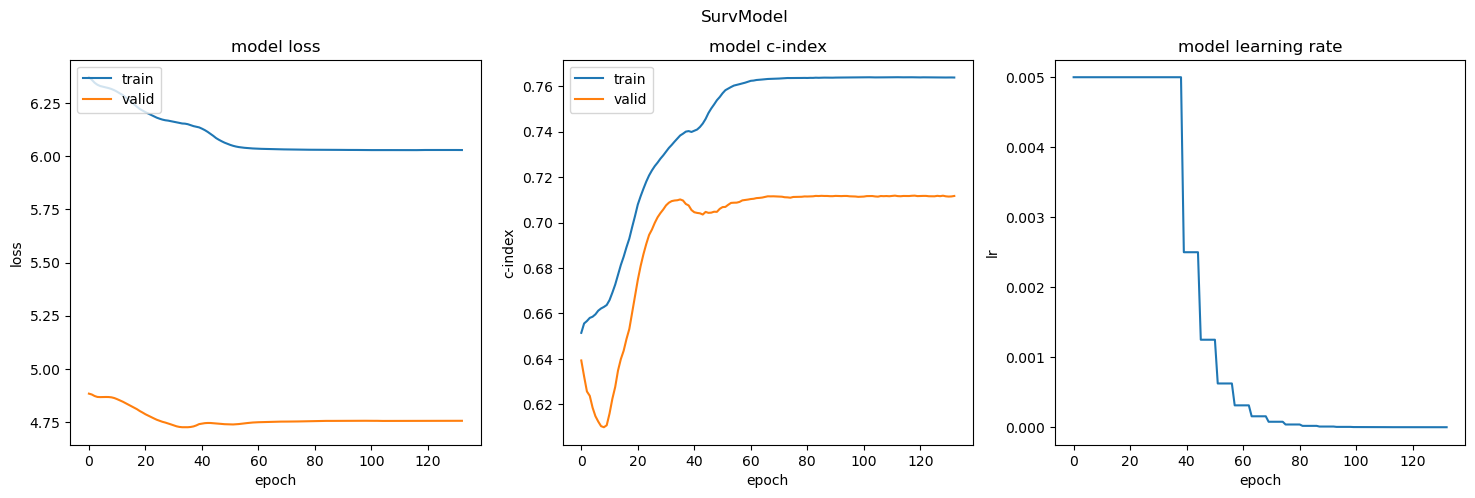

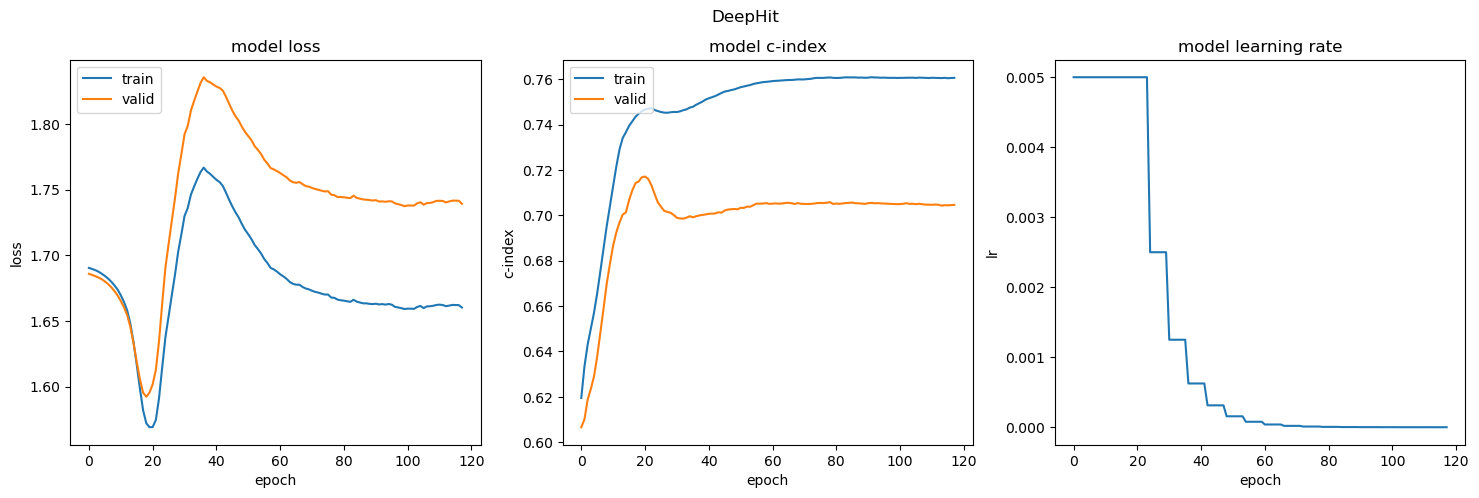

Fold 0
package concordance 0.674840590271452, surv concordance 0.7118181818181818, hit concordance 0.7171144892578672


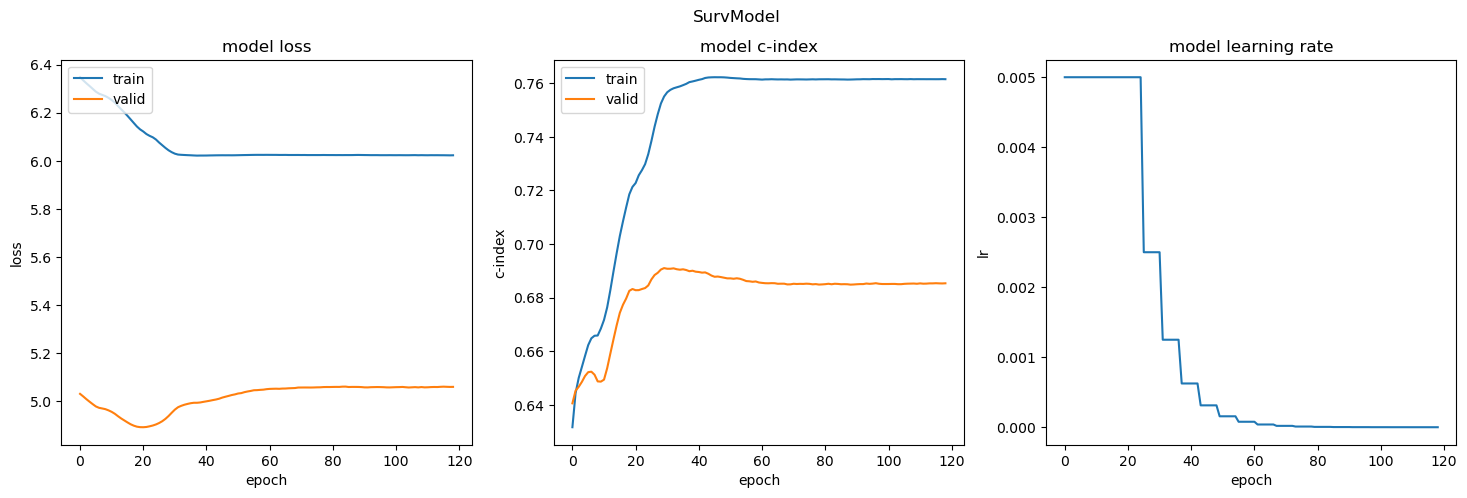

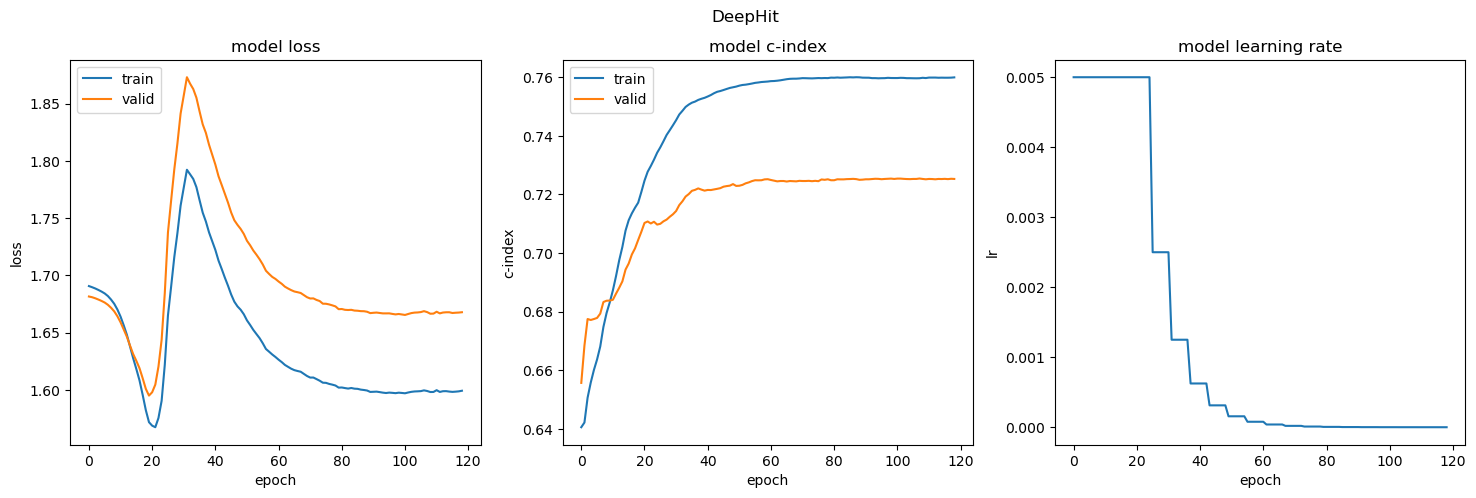

Fold 1
package concordance 0.5819279480280858, surv concordance 0.6910072369201566, hit concordance 0.7254407321580476


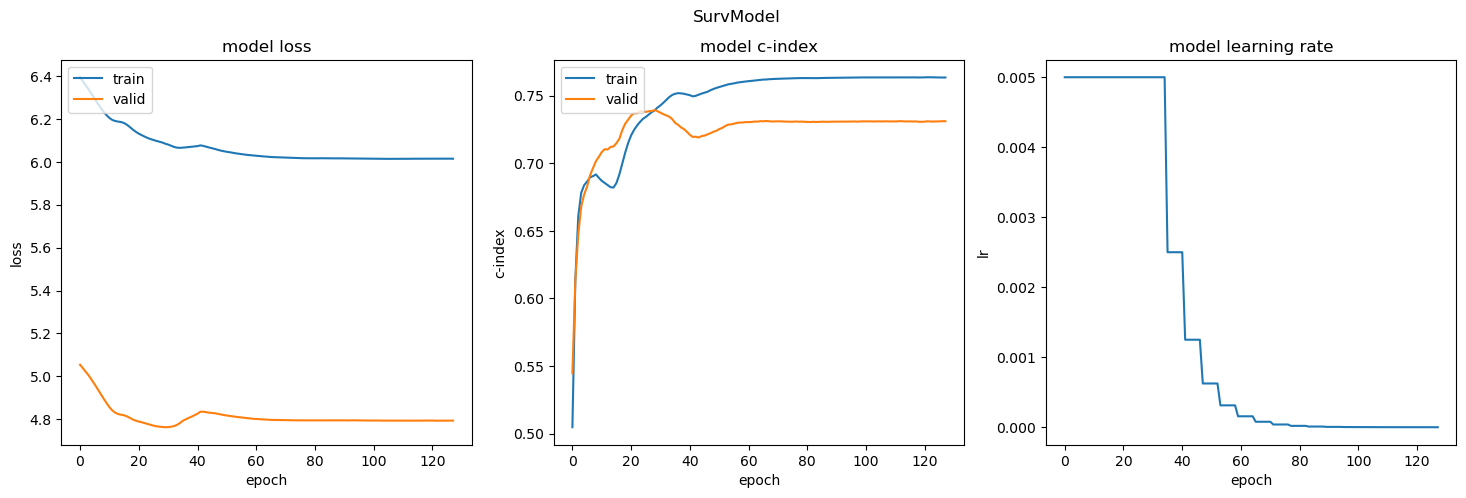

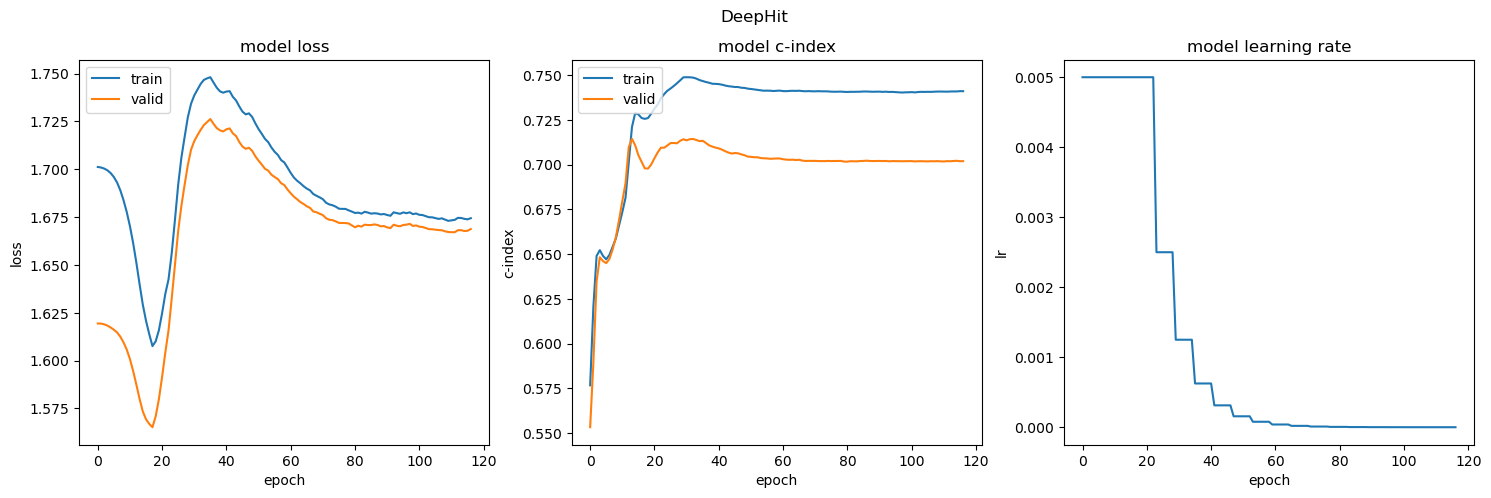

Fold 2
package concordance 0.649221410387807, surv concordance 0.7393760670495111, hit concordance 0.7144594060609745


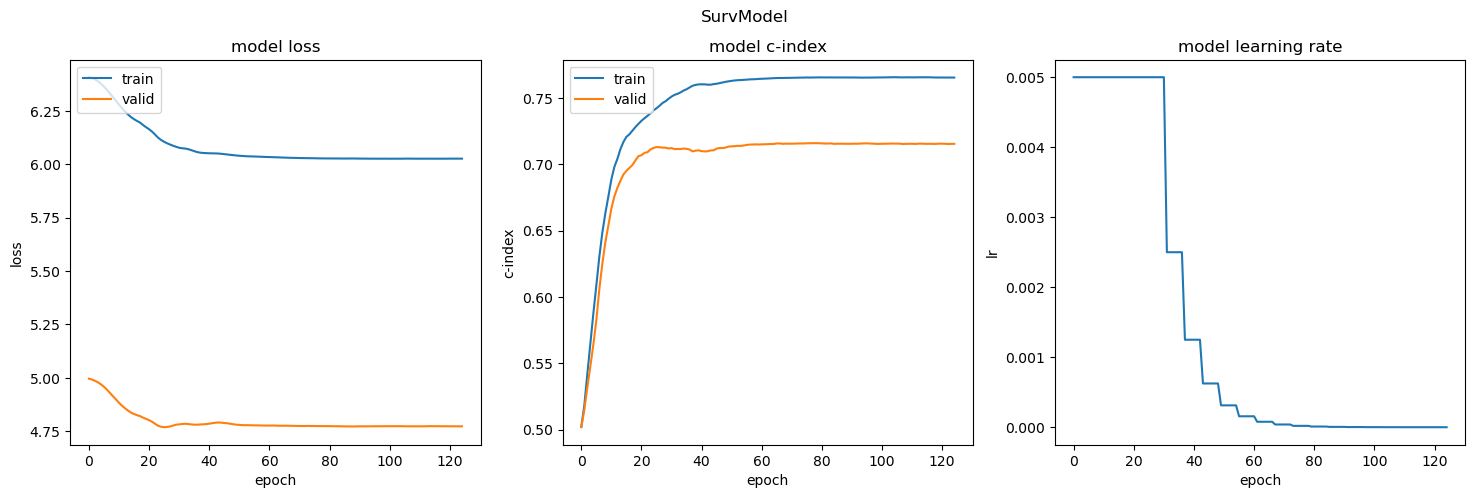

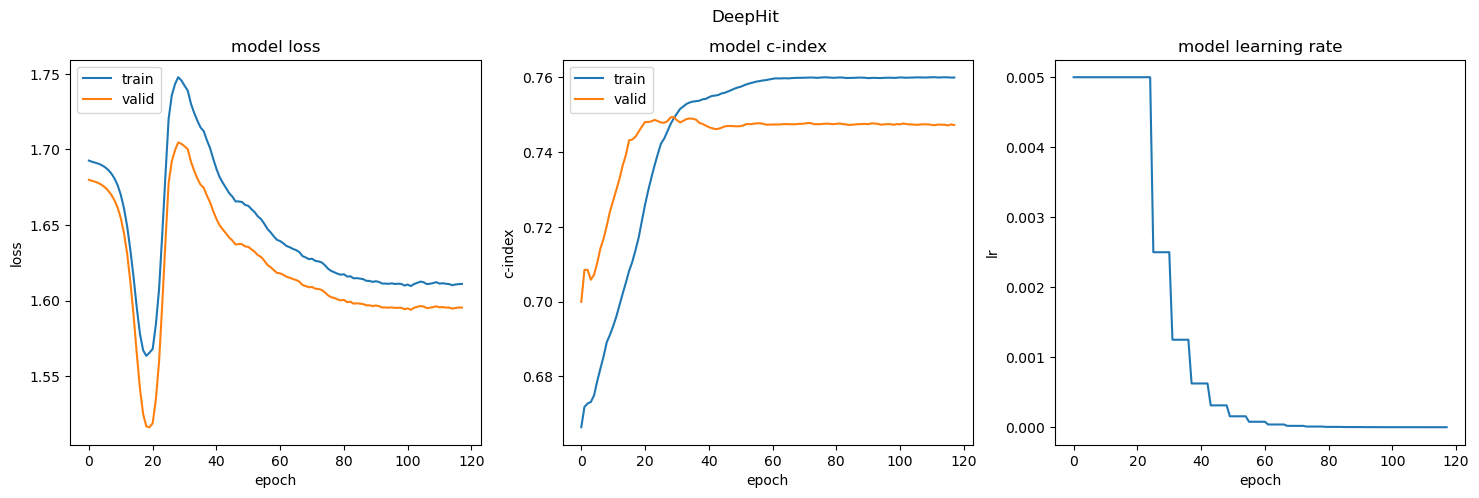

Fold 3
package concordance 0.5786380817387196, surv concordance 0.7158950443870098, hit concordance 0.7493400491549594


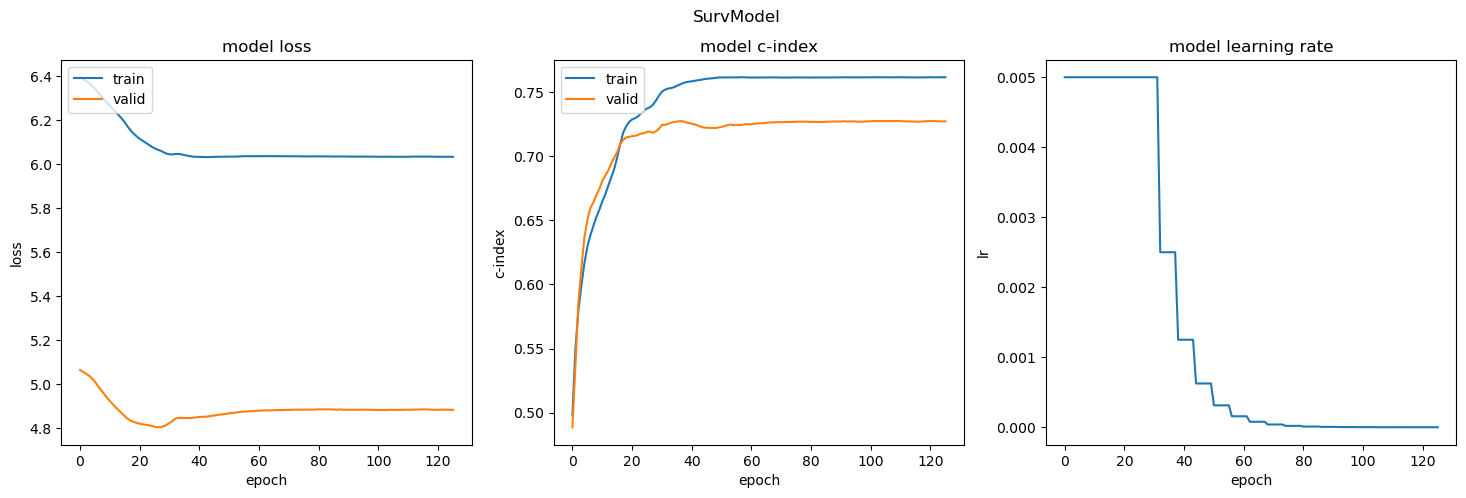

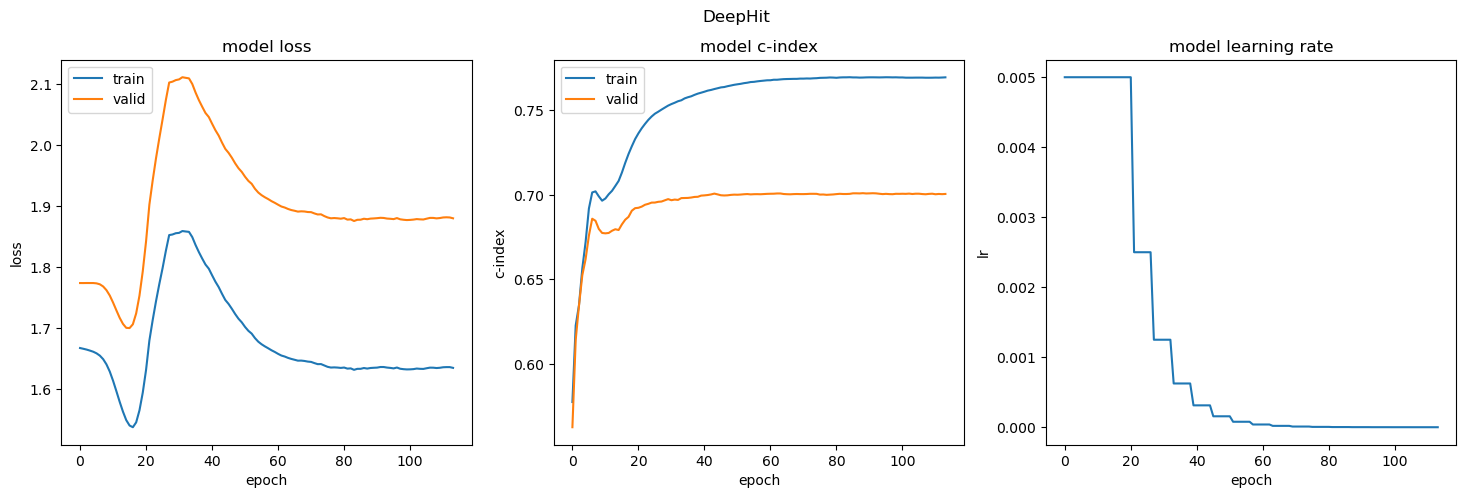

Fold 4
package concordance 0.6429817379231783, surv concordance 0.7274598480895228, hit concordance 0.7009623999306378
oof concordance, hit 0.702403484207786, surv 0.6949852362089305 


C:\Users\User\AppData\Local\Temp\ipykernel_26676\2878430814.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), torch.tensor(hit_model.mask )))


In [55]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)


TIME_BINS = 10
BATCH_SIZE = 99999

oof_preds_surv = np.zeros((df_train.shape[0], 1))
oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))

for i, (train_index, test_index) in enumerate(kf.split(df_train)):

    train = df_clear.iloc[train_index]
    valid = df_clear.iloc[test_index]

    model = SurvModel(df_train.copy(), batch_size=BATCH_SIZE, events_col=event_col, time_col=duration_col, layers = [16,16,16,16], residual=True)
    
    history_surv = model.fit(epochs=300, lr=0.005, verbose=False, train_index=train_index, valid_index=test_index)
    oof_preds_surv[test_index] = model.predict(test_index)
    utils.plot_history(history_surv, 'SurvModel')

    hit_model = DeepHitModel(df_train.copy(), batch_size=BATCH_SIZE, events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=10, layers = [64] * 6, dropout=0.3)
    history_hit = hit_model.fit(epochs=300, train_index=train_index, valid_index=test_index, lr=0.005, verbose=False)



    oof_preds_hit[test_index] = hit_model.predict(test_index)
    utils.plot_history(history_hit, 'DeepHit')

    num_durations = 10
    labtrans = DeepHitSingle.label_transform(num_durations)

    x = train.drop([event_col, duration_col], axis=1).values.astype('float32')
    y = labtrans.fit_transform(train[duration_col].values, train[event_col].values)
    
    val_x = valid.drop([event_col, duration_col], axis=1).values.astype('float32')
    val_y = labtrans.fit_transform(valid[duration_col].values, valid[event_col].values)


    in_features = x.shape[1]
    num_nodes = [64, 32, 16]
    out_features = num_durations
    batch_norm = True
    dropout = 0.1
    output_bias = False
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias = output_bias).float()

    m = DeepHitSingle(net, tt.optim.Adam)
    m.optimizer.set_lr(0.01)
    log = m.fit(x, y, batch_size=BATCH_SIZE, epochs=50, verbose=False)

    surv = m.predict_surv_df(val_x)
    ev = EvalSurv(surv, val_y[0], val_y[1], censor_surv='km')

    print(f'Fold {i}')
    #print(f'loss {losses.negative_likelihood_loss(valid_preds, torch.tensor(valid[duration_col].values, dtype=torch.float))}') 
    print(f'package concordance {ev.concordance_td("antolini")}, surv concordance {np.max(history_surv["val_c_index"])}, hit concordance {np.max(history_hit["val_c_index"])}')
hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), torch.tensor(hit_model.mask )))
surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), (torch.tensor(model.x), torch.tensor(model.events), torch.tensor(model.time)))
print(f'oof concordance, hit {hit_oof}, surv {surv_oof} ')


In [25]:
df_train.head()

age  creatinine  kappa  lambda  death  futime  flc.grp_2  flc.grp_3  \
7755  51.0    1.093516   1.96    2.08   True  4974.0          0          0   
196   81.0    1.000000   1.68    1.46  False  2434.0          0          0   
4471  64.0    0.900000   1.25    1.05   True  4683.0          0          1   
7682  51.0    1.200000   0.77    1.23   True  3771.0          1          0   
415   85.0    0.800000   1.97    2.08  False   278.0          0          0   

      flc.grp_4  flc.grp_5  flc.grp_6  flc.grp_7  flc.grp_8  flc.grp_9  \
7755          0          0          0          0          0          1   
196           0          0          0          1          0          0   
4471          0          0          0          0          0          0   
7682          0          0          0          0          0          0   
415           0          0          0          0          0          1   

      flc.grp_10  mgus_yes  sample.yr_1996  sample.yr_1997  sample.yr_1998  \
7755           0         0               0               0               0   
196            0         0               0               1               0   
4471           0         0               1               0               0   
7682           0         0               0               0               0   
415            0         0               0               0               1   

      sample.yr_1999  sample.yr_2000  sample.yr_2001  sample.yr_2002  \
7755               0               0               0               0   
196                0               0               0               0   
4471               0               0               0               0   
7682               1               0               0               0   
415                0               0               0               0   

      sample.yr_2003  sex_M  
7755               0      0  
196                0      1  
4471               0      0  
7682               0      0  
415                0      0

In [88]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import gc

def train_hit(config):
    TIME_BINS = config["time_bins"]

    df, event_col, duration_col  = df_func(missing_values_strategy=config["missing_values_strategy"])
    df_train, df_test = utils.split_dataset(df)

    oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))
    for i, (train_index, test_index) in enumerate(kf.split(df_train)):        

        hit_model = DeepHitModel(df_train.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=config["interpolation_steps"]
                                 , layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"], residual=True, batch_size=config["batch_size"])
        hit_model.fit(epochs=50, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, track_history=False, weight_decay=config["weight_decay"])
        oof_preds_hit[test_index] = hit_model.predict(test_index)
    

    hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), hit_model.mask))
    hit_oof_loss = losses.deep_hit_loss(torch.tensor(oof_preds_hit), hit_model.mask).detach().numpy()
    del hit_model, oof_preds_hit
    gc.collect()
    tune.report(loss = hit_oof_loss, c_index=hit_oof)

def train_surv(config):
    
    df, event_col, duration_col  = df_func(missing_values_strategy=config["missing_values_strategy"])
    df_train, df_test = utils.split_dataset(df)

    oof_preds_surv = np.zeros((df_train.shape[0], 1))
    for i, (train_index, test_index) in enumerate(kf.split(df_train)):    
        model = SurvModel(df_train.copy(), events_col=event_col, time_col=duration_col, layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"],
                            residual=True, batch_size=config["batch_size"])
        model.fit(epochs=50, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, track_history=False, weight_decay=config["weight_decay"])
        
        oof_preds_surv[test_index] = model.predict(test_index)

    surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), (torch.tensor(model.x), torch.tensor(model.events), torch.tensor(model.time)))
    surv_oof_loss = losses.negative_likelihood_loss(torch.tensor(oof_preds_surv), torch.tensor(model.events, dtype=torch.float)).detach().numpy()
    del model, oof_preds_surv
    gc.collect()
    tune.report(loss = surv_oof_loss, c_index=surv_oof)


hit_space = {
    "lr": tune.uniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64, 128, 256]),
    "num_layers": tune.choice([6, 7, 8, 9, 10, 12]),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "time_bins": tune.choice([10, 20, 30, 40, 50]),
    "interpolation_steps": tune.choice([5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
    "batch_size": tune.choice([32, 64, 128, 256, 512, 1024, 99999]),
    "activation": tune.choice(["relu", "elu", "leaky_relu", "selu", "gelu"]),
    "missing_values_strategy": tune.choice(["mean", "median", "drop"])
}

surv_space = {
    "lr": tune.uniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64, 128, 256]),
    "num_layers": tune.choice([6, 7, 8, 9, 10, 12],),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([1024, 99999]),
    "activation": tune.choice(["relu", "elu", "leaky_relu", "selu", "gelu"]),
    "missing_values_strategy": tune.choice(["mean", "median", "drop"])
}

(bundle_reservation_check_func pid=32548) [2023-06-07 09:28:33,732 C 32548 31016] core_worker.cc:2508:  Check failed: _s.ok() Bad status: IOError: Unknown error
(bundle_reservation_check_func pid=32548) *** StackTrace Information ***
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check_func pid=32548) PyInit__raylet
(bundle_reservation_check

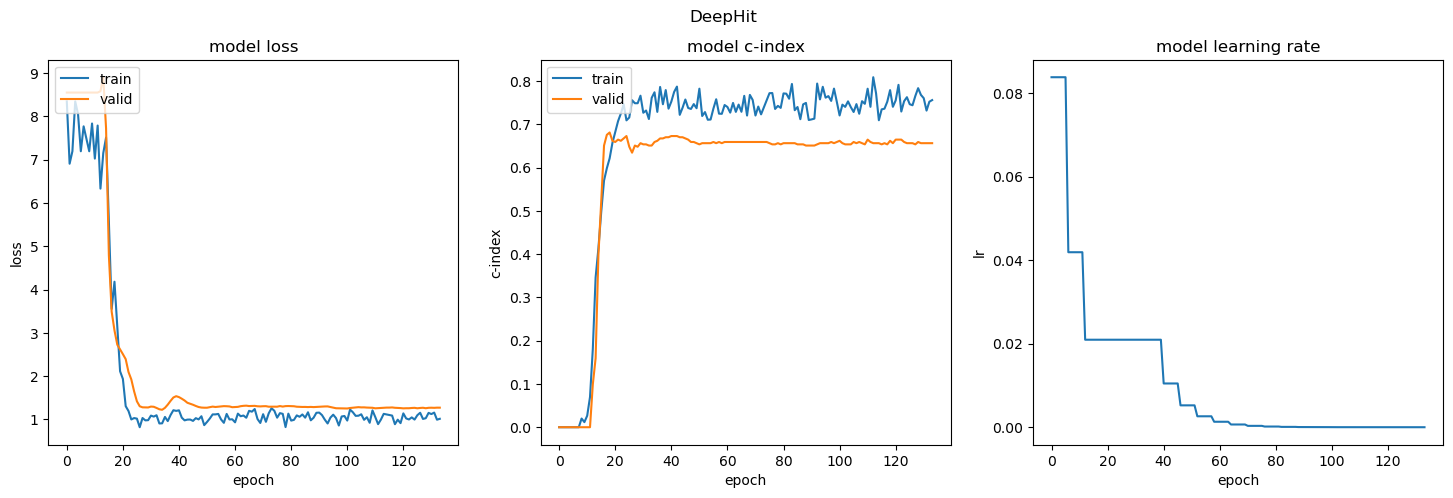

2023-06-07 09:43:18,845	INFO tune.py:798 -- Total run time: 376.39 seconds (376.15 seconds for the tuning loop).


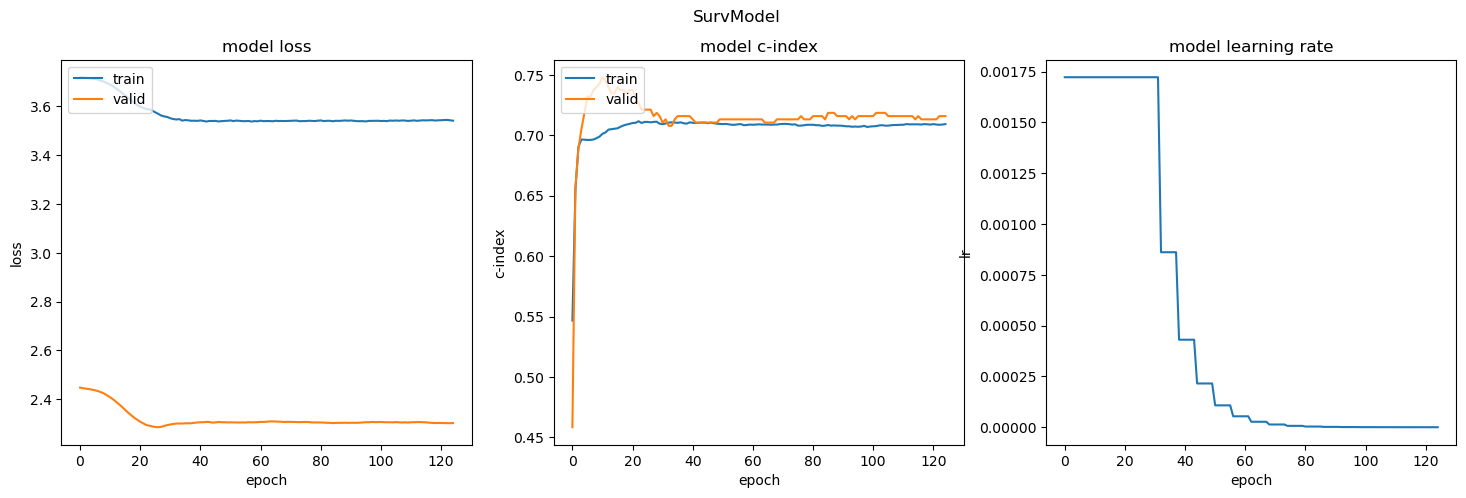

Dataset: get_veterans_lugn_cancer, hit best config {'lr': 0.08381530863626348, 'dropout': 0.20874898187915797, 'layer_size': 128, 'num_layers': 10, 'weight_decay': 0.0010048526013591345, 'time_bins': 20, 'interpolation_steps': 40, 'batch_size': 64, 'activation': 'selu', 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.001722796865751974, 'dropout': 0.1890129417015594, 'layer_size': 64, 'num_layers': 8, 'weight_decay': 0.00027630048568455854, 'batch_size': 1024, 'activation': 'elu', 'missing_values_strategy': 'median'}
hit concordance 0.6593406593406593, surv concordance 0.7211796246648794, cph concordance 0.6813186813186813


2023-06-07 10:14:14,389	INFO tune.py:798 -- Total run time: 1849.11 seconds (1848.82 seconds for the tuning loop).


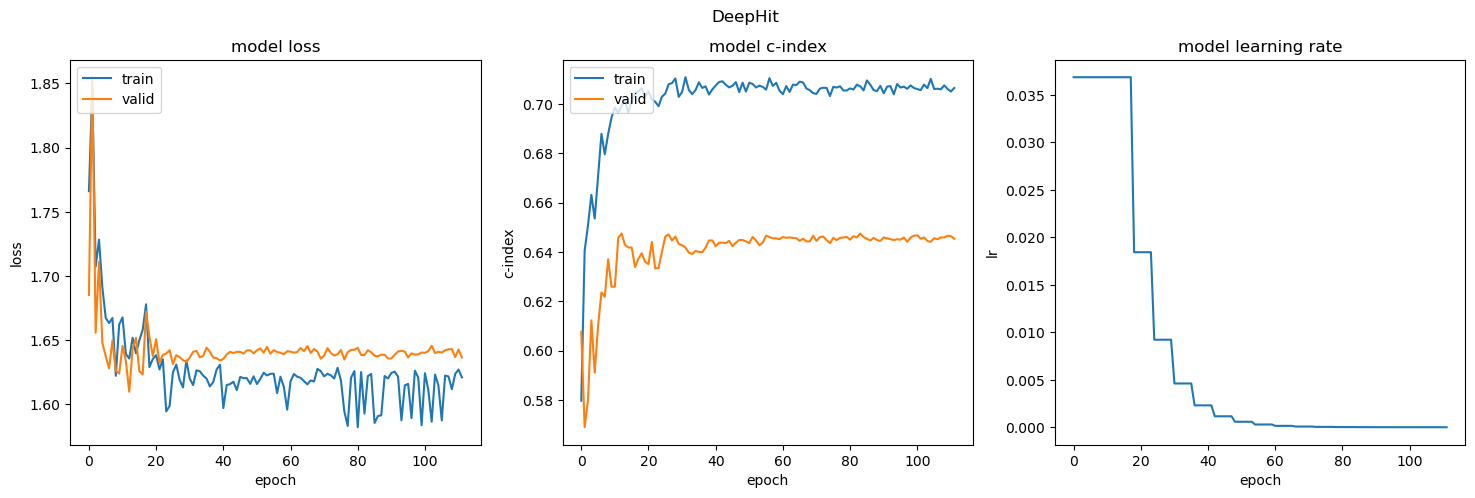

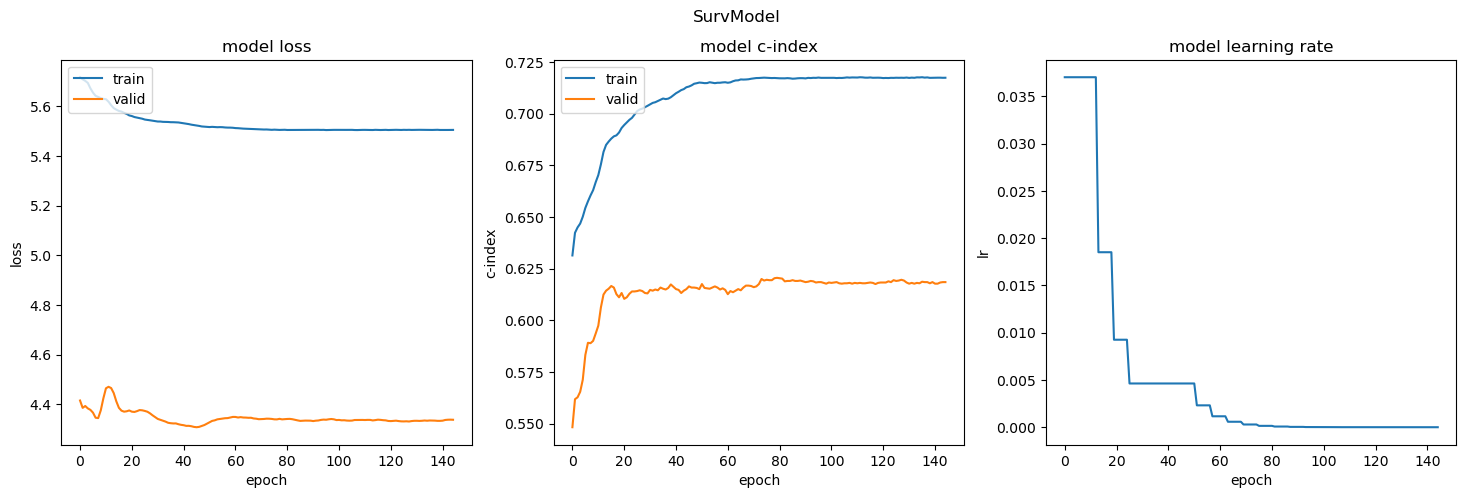

Dataset: get_gbsg2, hit best config {'lr': 0.03685622155411118, 'dropout': 0.15988345697091366, 'layer_size': 16, 'num_layers': 7, 'weight_decay': 0.0033921101183561897, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 32, 'activation': 'selu', 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.037034929683798394, 'dropout': 0.11433550997179341, 'layer_size': 16, 'num_layers': 6, 'weight_decay': 0.0748854589080671, 'batch_size': 1024, 'activation': 'leaky_relu', 'missing_values_strategy': 'drop'}
hit concordance 0.6474858356940509, surv concordance 0.6163841807909605, cph concordance 0.6680240793201133


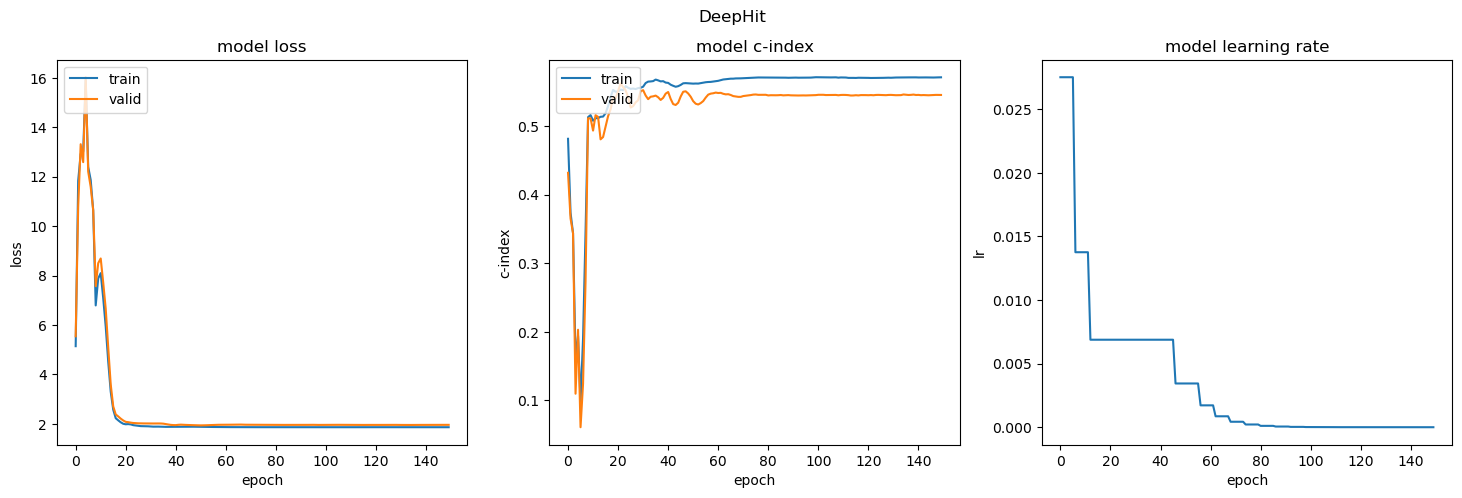

2023-06-07 11:17:23,885	ERROR trial_runner.py:1062 -- Trial train_surv_d5642_00007: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=38856, ip=127.0.0.1, repr=train_surv)
  File "python\ray\_raylet.pyx", line 857, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 861, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 803, in ray._raylet.execute_task.function_executor
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\tune\trainable\trainable.py", line 368, in train
    raise skipped from exception_cause(skipped)
  File "d:\Users\User\

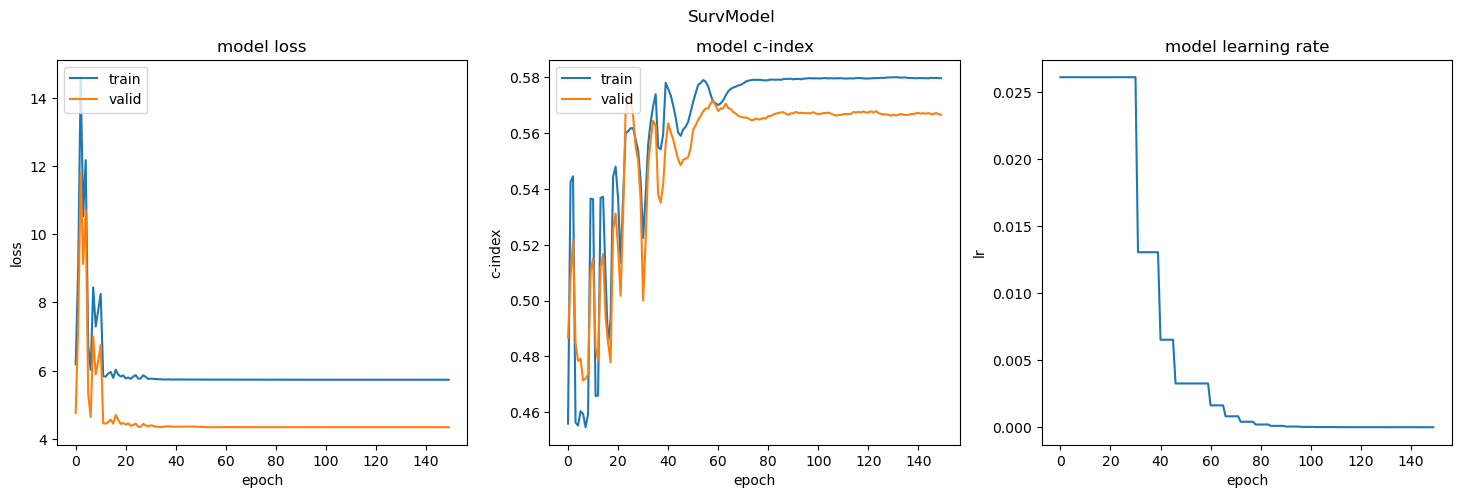

Dataset: get_aids, hit best config {'lr': 0.02751368893098091, 'dropout': 0.20226145583272875, 'layer_size': 128, 'num_layers': 12, 'weight_decay': 0.0006690302505233847, 'time_bins': 20, 'interpolation_steps': 45, 'batch_size': 99999, 'activation': 'leaky_relu', 'missing_values_strategy': 'mean'}, surv best config {'lr': 0.026081155824037854, 'dropout': 0.1122571540293269, 'layer_size': 64, 'num_layers': 8, 'weight_decay': 0.0009789443798419392, 'batch_size': 99999, 'activation': 'leaky_relu', 'missing_values_strategy': 'drop'}
hit concordance 0.5455925653294075, surv concordance 0.5665344392354851, cph concordance 0.5813857195436143


In [89]:
df_functions = [utils.get_veterans_lugn_cancer, utils.get_gbsg2, utils.get_aids] 
                #utils.get_metabric, utils.get_whas500, 
                #utils.get_flchain]
for df_func in df_functions:
    
    tuner_hit = tune.Tuner(
        train_hit,
        tune_config=tune.TuneConfig(
            metric="c_index",
            mode="max",
            num_samples=200,
            max_concurrent_trials=4
        ),
        param_space=hit_space
    )
    analysis_hit = tuner_hit.fit()

    hit_config = analysis_hit.get_best_result(metric="c_index", mode="max", scope="all").config
    
    df, event_col, duration_col  = df_func(missing_values_strategy=hit_config["missing_values_strategy"])
    df = df.reset_index(drop=True)
    df_train, df_test = utils.split_dataset(df)

    train_index = df_train.index.values
    test_index = df_test.index.values

    hit_model = DeepHitModel(df.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=hit_config["interpolation_steps"]
                                 , layers = [hit_config["layer_size"]] * hit_config["num_layers"], dropout=hit_config["dropout"], residual=True, batch_size=hit_config["batch_size"])
    history = hit_model.fit(epochs=150, train_index=train_index, valid_index=test_index, lr=hit_config["lr"], verbose=False, track_history=True, weight_decay=hit_config["weight_decay"])
    utils.plot_history(history, 'DeepHit')
    hit_oof = hit_model.concordance_index(hit_model.predict(test_index), (torch.tensor(hit_model.x[test_index]), torch.tensor(hit_model.events[test_index]),
                                           torch.tensor(hit_model.time[test_index]), torch.tensor(hit_model.continous_time[test_index]), hit_model.mask[test_index]))
    tuner_surv = tune.Tuner(
        train_surv,
        tune_config=tune.TuneConfig(
            metric="c_index",
            mode="max",
            num_samples=200,
            max_concurrent_trials=4
        ),
        param_space=surv_space
    )
    analysis_surv = tuner_surv.fit()

    surv_config = analysis_surv.get_best_result(metric="c_index", mode="max", scope="all").config
    model = SurvModel(df.copy(), events_col=event_col, time_col=duration_col, layers = [surv_config["layer_size"]] * surv_config["num_layers"], dropout=surv_config["dropout"],
                            residual=True, batch_size=surv_config["batch_size"])
    history = model.fit(epochs=150, train_index=train_index, valid_index=test_index, lr=surv_config["lr"], verbose=False, track_history=True, weight_decay=surv_config["weight_decay"])
    utils.plot_history(history, 'SurvModel')
    surv_oof = model.concordance_index(model.predict(test_index),( torch.tensor(model.x[test_index]),
                                        torch.tensor(model.events[test_index]), torch.tensor(model.time[test_index])))
    cph = CoxPHFitter(penalizer=0.1)

    cph.fit(df_train, duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(df_test, scoring_method="concordance_index")

    print(f'Dataset: {df_func.__name__}, hit best config {hit_config}, surv best config {surv_config}')
    print(f'hit concordance {hit_oof}, surv concordance {surv_oof}, cph concordance {concordance_index}')
    

In [4]:
gene_df = pd.read_csv("brca_metabric/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt", sep="\t")

In [5]:

#gene_df.transpose()
#use Hugo_Symbol as column names
gene_df = gene_df.set_index('Hugo_Symbol').transpose()
pd.set_option('display.max_columns', 100)
#drop first row
gene_df = gene_df.iloc[1:]


In [38]:
utils.get_metabric(missing_values_strategy="mean", gene_data=True)[0]

Age at Diagnosis  Cohort  Lymph nodes examined positive  \
0                75.65     1.0                           10.0   
1                43.19     1.0                            0.0   
2                48.87     1.0                            1.0   
3                47.68     1.0                            3.0   
4                76.97     1.0                            8.0   
...                ...     ...                            ...   
1980             43.10     4.0                            1.0   
1981             42.88     4.0                            1.0   
1982             62.90     4.0                           45.0   
1983             61.16     4.0                           12.0   
1984             60.02     4.0                            1.0   

      Nottingham prognostic index  Overall Survival (Months)  Tumor Size  \
0                           6.044                 140.500000        22.0   
1                           4.020                  84.633333        10.0   
2                           4.030                 163.700000        15.0   
3                           4.050                 164.933333        25.0   
4                           6.080                  41.366667        40.0   
...                           ...                        ...         ...   
1980                        5.050                 196.866667        25.0   
1981                        5.040                  44.733333        20.0   
1982                        6.050                 175.966667        25.0   
1983                        5.050                  86.233333        25.0   
1984                        5.040                 201.900000        20.0   

      Tumor Stage  Event  DOCK10   SGIP1     AMH    PLEC   STRN4  POLR2C  \
0        2.000000  False -1.0277 -1.3162 -0.7131 -0.5323  0.1010  0.0854   
1        1.000000  False -1.1874 -0.5899 -0.7687 -0.7315 -0.1117  0.3587   
2        2.000000   True  0.4436  0.8861  0.0347 -1.3888 -0.8847  0.4201   
3        2.000000  False  0.0297  1.8420 -0.8469  1.8261  0.5799  0.8880   
4        2.000000   True  4.4968 -0.4274 -1.1265  1.3664 -2.2860  0.3021   
...           ...    ...     ...     ...     ...     ...     ...     ...   
1980     1.736016  False  0.3302  0.7557 -0.0288 -0.4840 -0.5621  0.0140   
1981     1.736016   True -0.3231  0.0577 -0.6491  0.2500 -0.0720  1.3999   
1982     1.736016   True -0.2043 -0.8216 -0.4543 -1.2715 -0.9548  1.8874   
1983     1.736016   True  0.2134 -0.5207  0.0972 -0.0855 -1.4057  0.4331   
1984     1.736016   True  0.6128  1.3127 -0.9379  0.1034 -1.5395  0.3107   

        LYG1     EFS   KLHL8  SLC25A1  SLC6A6  LOC442028    IDNK  ZCCHC7  \
0    -0.2401  0.9100  0.0011   1.5844 -1.6621     2.3404 -0.1076  0.0189   
1     0.6058  0.9757 -1.1478   0.9034 -1.4946    -0.6322  0.9354  1.4947   
2    -0.8730 -0.5991 -1.5329  -0.9361  0.2490    -0.0603  0.3112  0.7411   
3    -1.2916 -1.4848 -1.4905   0.7616 -0.1291     1.1013 -0.6497  0.6594   
4    -1.0733 -0.3486 -0.3875   0.8179 -0.8940    -0.5206  0.8944 -0.8611   
...      ...     ...     ...      ...     ...        ...     ...     ...   
1980 -1.1946 -0.8390 -0.8056  -0.6473  0.3391    -0.9331  0.0939  0.4262   
1981 -1.1149 -0.6349 -0.7044   1.2054  0.6673    -0.9847 -0.8266 -0.1746   
1982 -0.8368 -0.4591 -1.0768  -0.5733  0.5375     0.1252  0.4884 -0.6890   
1983 -0.3862  0.3017 -1.0454   0.7385  0.3118     0.3650  0.5460  0.2998   
1984  0.1052  1.3184 -0.6772  -0.4244  0.7325    -0.0089 -0.5153  0.9565   

      ZBTB44   SFXN2  IZUMO4  BCORL1    EHD3    COQ9  MIS18BP1  C21orf99  \
0    -0.4822 -0.6365  0.5323  0.4501 -1.0188  0.4116   -0.3385    1.1198   
1    -0.0125  1.0374 -0.6482 -0.2315  0.1136 -0.1300    0.2197   -1.6318   
2     2.1672  0.4533 -0.4547 -1.1561 -0.7698 -0.4682    1.0709   -1.9799   
3     0.5581 -0.4240  0.0502 -0.8245 -0.2528 -0.1419    1.2544   -0.5677   
4    -0.1859  0.0614 -0.5801 -0.0659 -1.0157  0.4701   -0.8441    0.7317   
...      ...     ...     ...  

In [21]:
len(set(list(df["Patient ID"].values)) - set(list(gene_df.index.values)))

529

In [3]:
df_clear, event_col, duration_col = utils.get_metabric(missing_values_strategy="mean", gene_data=True)


In [24]:
df_train, df_test = utils.split_dataset(df_clear)
df_train, df_valid = utils.split_dataset(df_train)

In [4]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)
col_to_score = {}
for column in df_train.columns:
    if column not in [event_col, duration_col]:
        df_sub = df_train[[event_col, duration_col, column]]
        cph = CoxPHFitter(penalizer=0.1)
        cph.fit(df_sub, duration_col = duration_col, event_col = event_col)
        concordance_index = cph.score(df_valid[[event_col, duration_col, column]], scoring_method="concordance_index")
        col_to_score[column] = concordance_index

In [5]:
sorted_cols = sorted(col_to_score.items(), key=lambda x: x[1], reverse=True)
sorted_cols_names = [x[0] for x in sorted_cols]

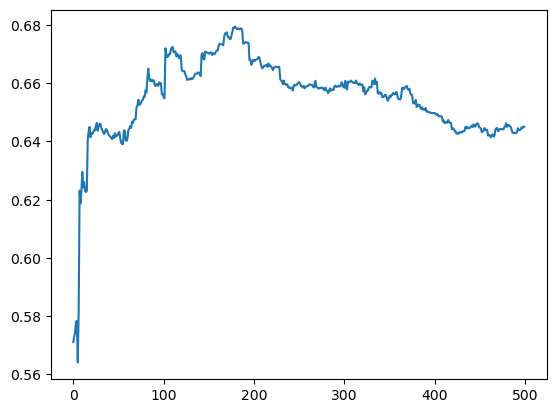

In [6]:
concordance_indexes = []
for i in range(500):    
    picked_cols = [event_col, duration_col] + sorted_cols_names[:i+1]

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(df_train[picked_cols], duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(df_test[picked_cols], scoring_method="concordance_index")
    concordance_indexes.append(concordance_index)
plt.plot(concordance_indexes)

In [7]:
print(f'Best concordance index: {np.max(concordance_indexes)}, num features {np.argmax(concordance_indexes)}')
concordance_indexes[180]

Best concordance index: 0.679478514513375, num features 179


0.6790338645418327

In [25]:
cph = CoxPHFitter(penalizer=0.1)
picked_cols = [event_col, duration_col] + sorted_cols_names[:180]
df_train_and_valid = pd.concat([df_train, df_valid])
cph.fit(df_train_and_valid[picked_cols], duration_col = duration_col, event_col = event_col)
concordance_index = cph.score(df_test[picked_cols], scoring_method="concordance_index")
print(f'Best concordance index: {concordance_index}, num features {len(picked_cols)}')

Best concordance index: 0.6856324701195219, num features 182


In [29]:
while True:
    used_columns = list(summary.index.values[cols_mask]) + [event_col, duration_col]
    
    cph_tune = CoxPHFitter(penalizer=0.1)
    cph_tune.fit(df_train[used_columns], duration_col = duration_col, event_col = event_col)
    best_concordance_index = cph_tune.score(df_valid[used_columns], scoring_method="concordance_index")
    
    summary = cph_tune.summary.copy()
    cols_mask = [True] * len(summary.index.values)
    i=0
    while True:
        summary = summary.sort_values(by="p", ascending=False)
        cols_mask[i] = False
        summary.index.values[cols_mask]
        cph_tune = CoxPHFitter(penalizer=0.1)
        used_columns = list(summary.index.values[cols_mask]) + [event_col, duration_col]
        cph_tune.fit(df_train[used_columns], duration_col = duration_col, event_col = event_col)
        concordance_index = cph_tune.score(df_valid[used_columns], scoring_method="concordance_index")
        if concordance_index > best_concordance_index:
            best_concordance_index = concordance_index
            print(f'Best concordance index: {concordance_index}, num features {len(summary.index.values[cols_mask])}')
            break
        else:
            cols_mask[i] = True
        i += 1
        if i == len(cols_mask):
            break
    if i == len(cols_mask):
        break



Best concordance index: 0.6926943204328415, num features 179
Best concordance index: 0.6927534517931585, num features 178
Best concordance index: 0.6927830174733169, num features 177
Best concordance index: 0.6928421488336339, num features 176
Best concordance index: 0.6929308458741094, num features 175
Best concordance index: 0.6929899772344262, num features 174
Best concordance index: 0.6931969369955355, num features 173
Best concordance index: 0.6935517251574372, num features 172
Best concordance index: 0.6935812908375957, num features 171
Best concordance index: 0.6936108565177542, num features 170
Best concordance index: 0.6938178162788635, num features 169
Best concordance index: 0.6938769476391804, num features 168
Best concordance index: 0.6939360789994974, num features 167
Best concordance index: 0.6941430387606067, num features 166
Best concordance index: 0.6942021701209237, num features 165
Best concordance index: 0.6942613014812405, num features 164
Best concordance index: 

In [37]:
used_columns

['DOCK10',
 'SGIP1',
 'AMH',
 'PLEC',
 'STRN4',
 'POLR2C',
 'LYG1',
 'EFS',
 'KLHL8',
 'SLC25A1',
 'SLC6A6',
 'LOC442028',
 'IDNK',
 'ZCCHC7',
 'ZBTB44',
 'SFXN2',
 'IZUMO4',
 'BCORL1',
 'EHD3',
 'COQ9',
 'MIS18BP1',
 'C21orf99',
 'TENT5C',
 'ADGRG1',
 'CD226',
 'ACTN1',
 'NAT14',
 'UBE2D4',
 'SCML1',
 'HIST1H4J',
 'CD47',
 'PREX1',
 'GTF3C5',
 'BET1',
 'DDX41',
 'VN1R10P',
 'WEE2-AS1',
 'ENC1',
 'VANGL1',
 'Nottingham prognostic index',
 'Lymph nodes examined positive',
 'Event',
 'Overall Survival (Months)']

In [56]:
cph = CoxPHFitter(penalizer=0.1)
picked_cols = [event_col, duration_col] +  list(summary.index.values[cols_mask])
df_train_and_valid = pd.concat([df_train, df_valid])
cph.fit(df_train_and_valid[picked_cols], duration_col = duration_col, event_col = event_col)
concordance_index = cph.score(df_test[picked_cols], scoring_method="concordance_index")
print(f'Best concordance index: {concordance_index}, num features {len(picked_cols)}')

Best concordance index: 0.6711368810472396, num features 44


In [31]:
df_train = df_train_and_valid[picked_cols]
df_test = df_test[picked_cols]

In [68]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import gc

def train_hit(config):
    TIME_BINS = config["time_bins"]

    oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))
    for i, (train_index, test_index) in enumerate(kf.split(df_train)):        

        hit_model = DeepHitModel(df_train.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=config["interpolation_steps"]
                                 , layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"], residual=True, batch_size=config["batch_size"],
                                 activation=config["activation"])
        hit_model.fit(epochs=50, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, track_history=False, weight_decay=config["weight_decay"])
        oof_preds_hit[test_index] = hit_model.predict(test_index)
    

    hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), hit_model.mask))
    hit_oof_loss = losses.deep_hit_loss(torch.tensor(oof_preds_hit), hit_model.mask).detach().numpy()
    del hit_model, oof_preds_hit
    gc.collect()
    tune.report(loss = hit_oof_loss, c_index=hit_oof)

def train_surv(config):
    
    oof_preds_surv = np.zeros((df_train.shape[0], 1))
    for i, (train_index, test_index) in enumerate(kf.split(df_train)):    
        model = SurvModel(df_train.copy(), events_col=event_col, time_col=duration_col, layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"],
                            residual=True, batch_size=config["batch_size"], activation=config["activation"])
        model.fit(epochs=50, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, track_history=False, weight_decay=config["weight_decay"])
        
        oof_preds_surv[test_index] = model.predict(test_index)

    surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), (torch.tensor(model.x), torch.tensor(model.events), torch.tensor(model.time)))
    surv_oof_loss = losses.negative_likelihood_loss(torch.tensor(oof_preds_surv), torch.tensor(model.events, dtype=torch.float)).detach().numpy()
    del model, oof_preds_surv
    gc.collect()
    tune.report(loss = surv_oof_loss, c_index=surv_oof)

hit_space = {
    "lr": tune.uniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64, 128, 256]),
    "num_layers": tune.choice([6, 7, 8, 9, 10, 12]),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "time_bins": tune.choice([10, 20, 30, 40, 50]),
    "interpolation_steps": tune.choice([5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
    "batch_size": tune.choice([32, 64, 128, 256, 512, 1024, 99999]),
    "activation": tune.choice(["relu", "elu", "leaky_relu", "selu", "gelu"])#,
    #"missing_values_strategy": tune.choice(["mean", "median", "drop"])
}

surv_space = {
    "lr": tune.uniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64, 128, 256]),
    "num_layers": tune.choice([6, 7, 8, 9, 10, 12],),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([1024, 99999]),
    "activation": tune.choice(["relu", "elu", "leaky_relu", "selu", "gelu"])
    #,
    #"missing_values_strategy": tune.choice(["mean", "median", "drop"])
}

In [58]:
df, event_col, duration_col = utils.get_metabric(missing_values_strategy="mean", gene_data=True)
df = df.reset_index(drop=True)
df_train, df_test = utils.split_dataset(df)

In [59]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

2023-06-06 23:43:19,116	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.509 s, which may be a performance bottleneck.
2023-06-06 23:43:19,119	WARNING util.py:244 -- The `process_trial_result` operation took 0.512 s, which may be a performance bottleneck.
2023-06-06 23:43:19,119	WARNING util.py:244 -- Processing trial results took 0.512 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-06 23:43:19,120	WARNING util.py:244 -- The `process_trial_result` operation took 0.513 s, which may be a performance bottleneck.
2023-06-06 23:43:19,119	WARNING util.py:244 -- The `process_trial_result` operation took 0.512 s, which may be a performance bottleneck.
2023-06-06 23:43:19,119	WARNING util.py:244 -- Processing trial results took 0.512 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-06-06 23:43:19,120	WARNING util.py:244 -- The `process_trial_resul

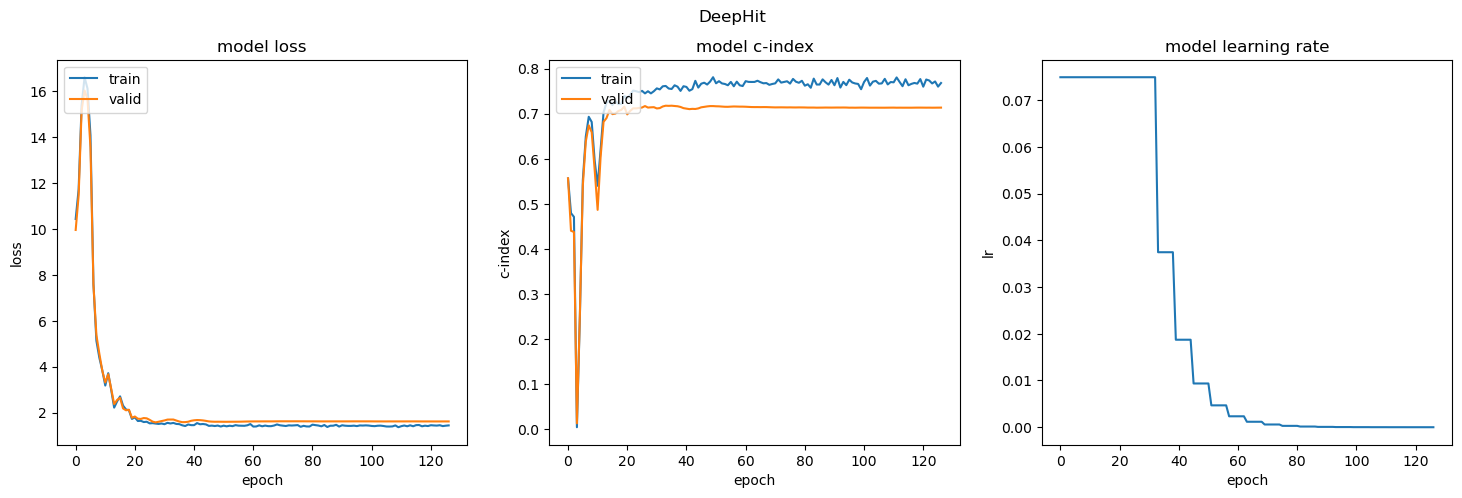

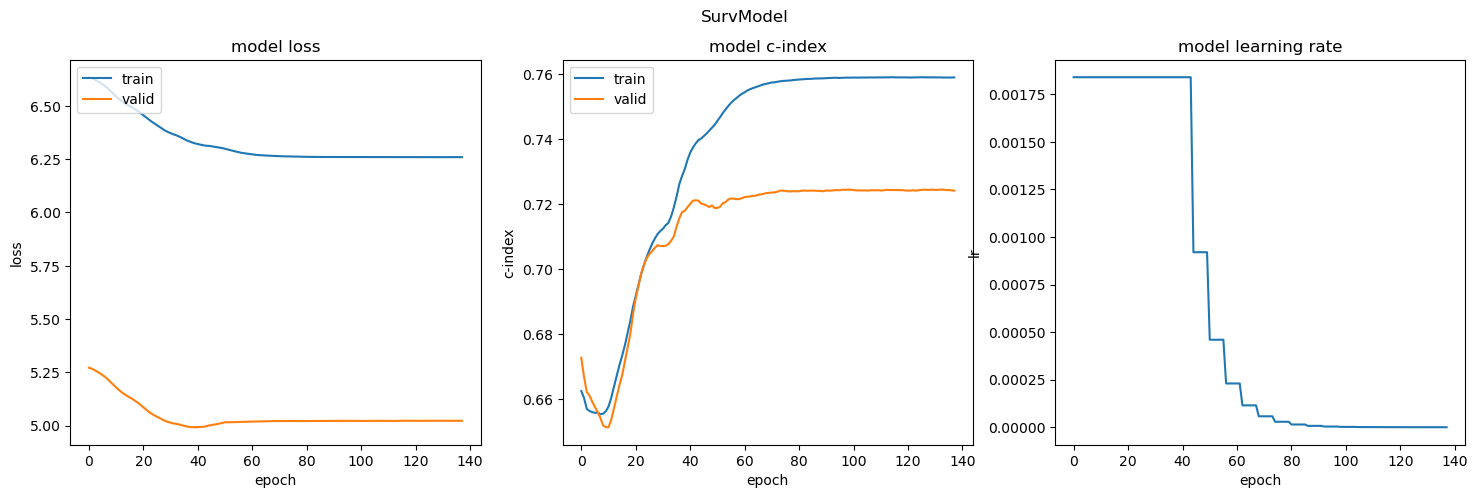

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.713663204325555, surv concordance 0.7179137644488431, cph concordance 0.6899366818440523
hit oof 0.724176264889852 surv_oof0.7157061407520504


In [79]:
tuner_hit = tune.Tuner(
    train_hit,
    tune_config=tune.TuneConfig(
        metric="c_index",
        mode="max",
        num_samples=500,
        max_concurrent_trials=4
    ),
    param_space=hit_space
)
analysis_hit = tuner_hit.fit()

hit_config = analysis_hit.get_best_result(metric="c_index", mode="max", scope="all").config

train_index = df_train.index.values
test_index = df_test.index.values

hit_model = DeepHitModel(df.copy(), events_col=event_col, time_col=duration_col, time_bins=hit_config["time_bins"], interpolation_steps=hit_config["interpolation_steps"]
                                , layers = [hit_config["layer_size"]] * hit_config["num_layers"], dropout=hit_config["dropout"], residual=True, batch_size=hit_config["batch_size"], 
                                activation=hit_config["activation"])
history = hit_model.fit(epochs=150, train_index=train_index, valid_index=test_index, lr=hit_config["lr"], verbose=False, track_history=True, weight_decay=hit_config["weight_decay"])
utils.plot_history(history, 'DeepHit')
hit_oof = hit_model.concordance_index(hit_model.predict(test_index), (torch.tensor(hit_model.x[test_index]), torch.tensor(hit_model.events[test_index]),
                                        torch.tensor(hit_model.time[test_index]), torch.tensor(hit_model.continous_time[test_index]), hit_model.mask[test_index]))
tuner_surv = tune.Tuner(
    train_surv,
    tune_config=tune.TuneConfig(
        metric="c_index",
        mode="max",
        num_samples=500,
        max_concurrent_trials=5
    ),
    param_space=surv_space
)
analysis_surv = tuner_surv.fit()

surv_config = analysis_surv.get_best_result(metric="c_index", mode="max", scope="all").config
model = SurvModel(df.copy(), events_col=event_col, time_col=duration_col, layers = [surv_config["layer_size"]] * surv_config["num_layers"], dropout=surv_config["dropout"],
                        residual=True, batch_size=surv_config["batch_size"], activation=surv_config["activation"])
history = model.fit(epochs=150, train_index=train_index, valid_index=test_index, lr=surv_config["lr"], verbose=False, track_history=True, weight_decay=surv_config["weight_decay"])
utils.plot_history(history, 'SurvModel')
surv_oof = model.concordance_index(model.predict(test_index),( torch.tensor(model.x[test_index]),
                                    torch.tensor(model.events[test_index]), torch.tensor(model.time[test_index])))
cph = CoxPHFitter(penalizer=0.1)

cph.fit(df_train, duration_col = duration_col, event_col = event_col)
concordance_index = cph.score(df_test, scoring_method="concordance_index")

print(f'Dataset: , hit best config {hit_config}, surv best config {surv_config}')
print(f'hit concordance {hit_oof}, surv concordance {surv_oof}, cph concordance {concordance_index}')
print(f'hit oof {analysis_hit.get_best_result(metric="c_index", mode="max", scope="all").metrics["c_index"]} surv_oof{analysis_surv.get_best_result(metric="c_index", mode="max", scope="all").metrics["c_index"]}')


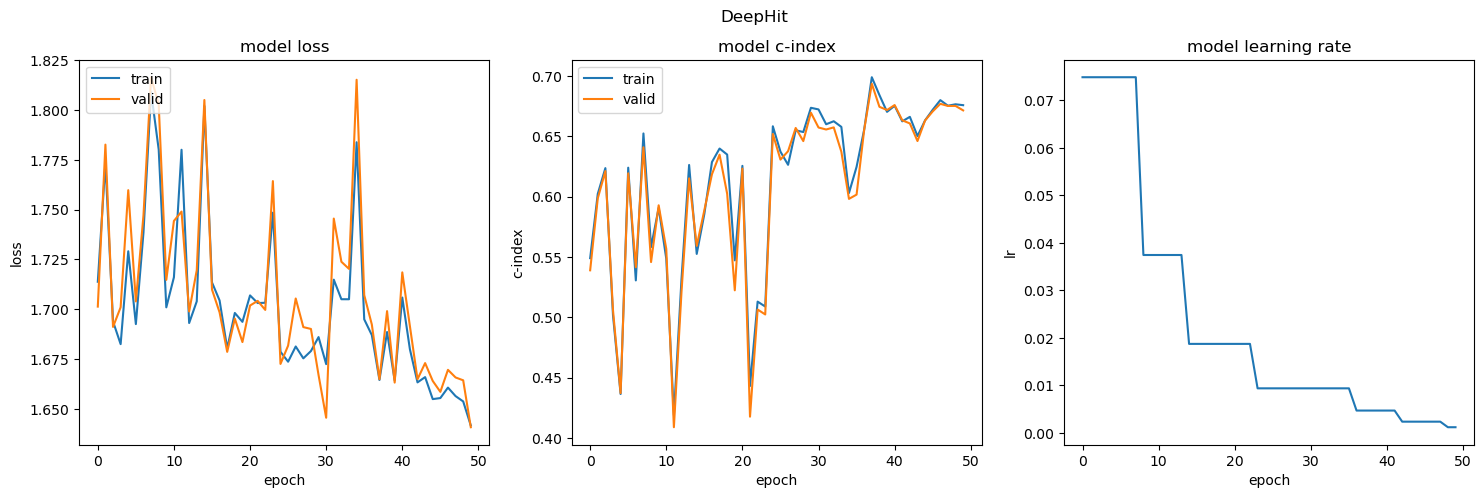

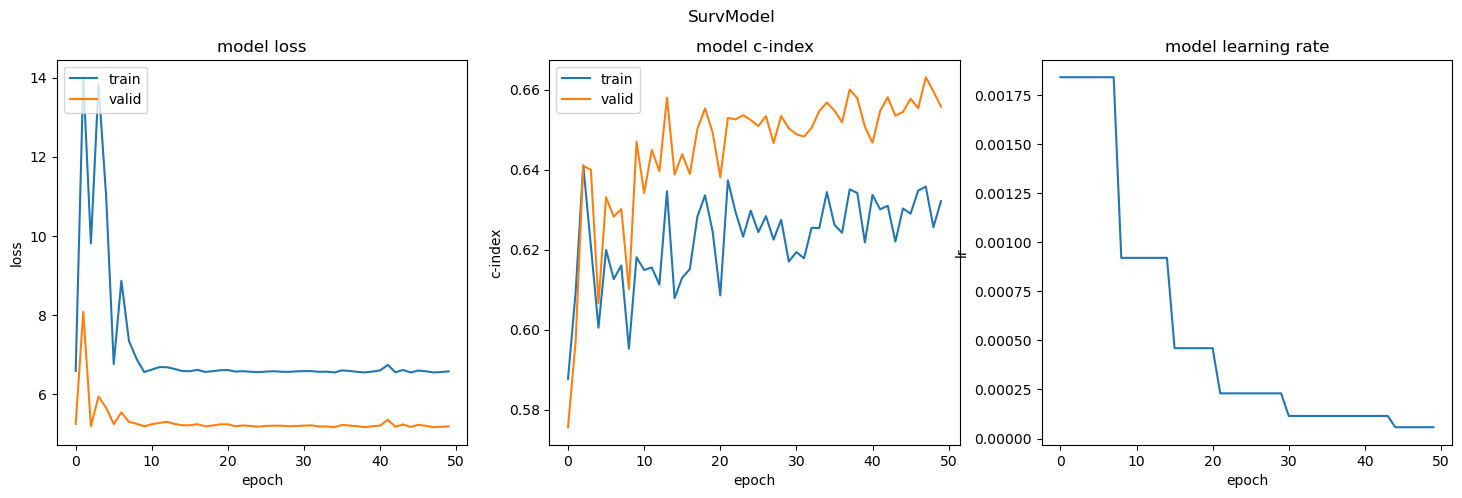

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.6715993170176437, surv concordance 0.6557300517263916, cph concordance 0.6899366818440523


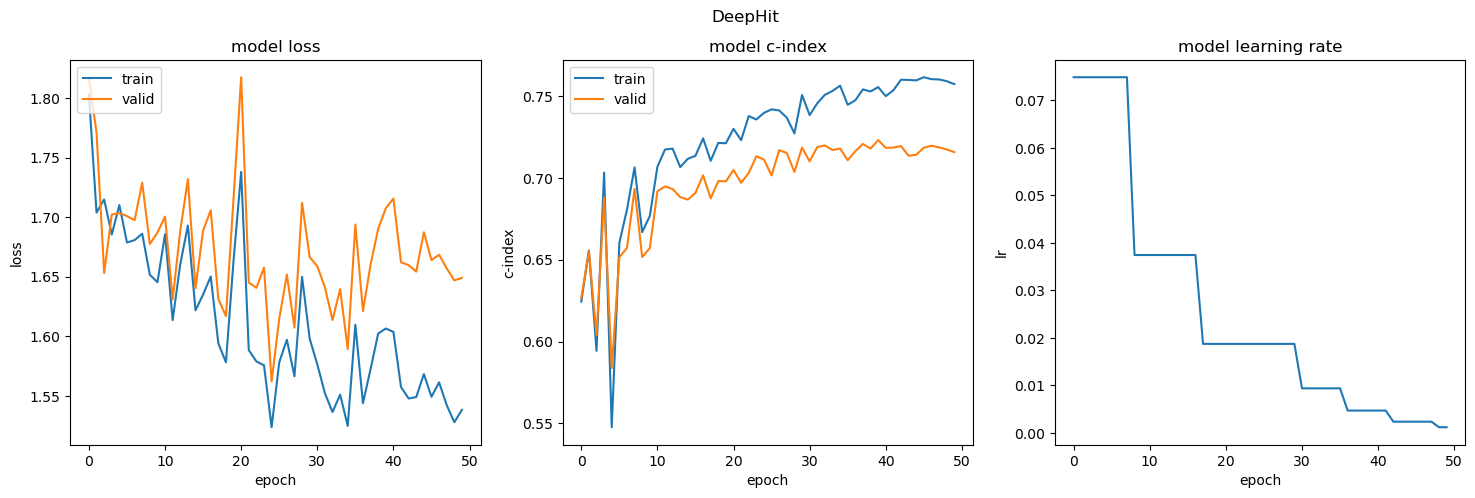

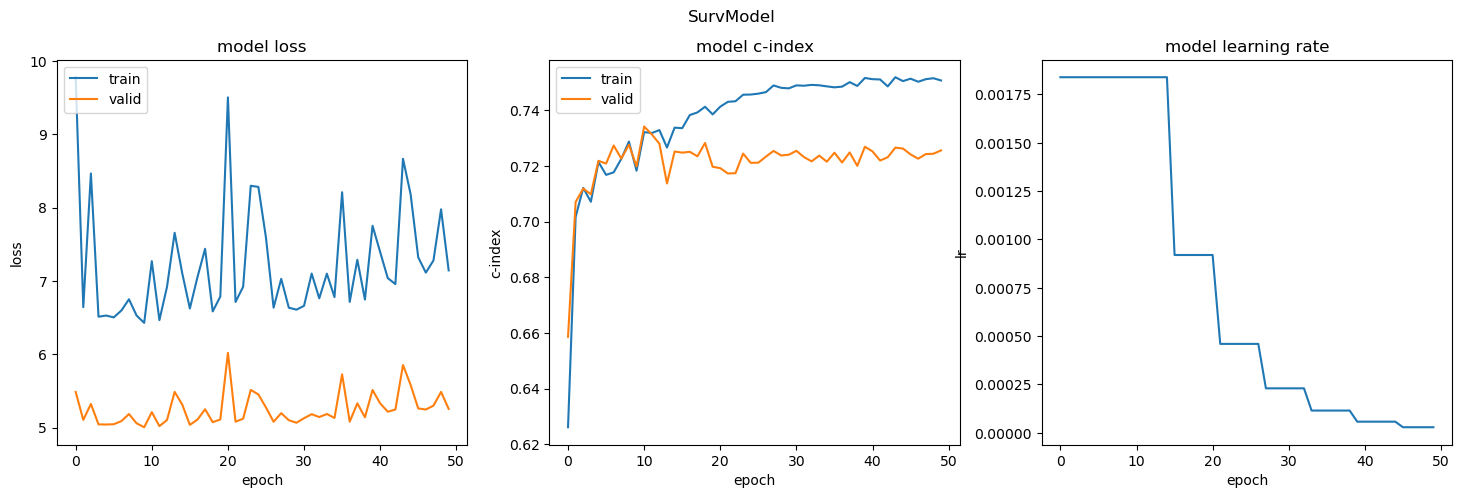

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.7156908081957882, surv concordance 0.7256260387294355, cph concordance 0.6899366818440523


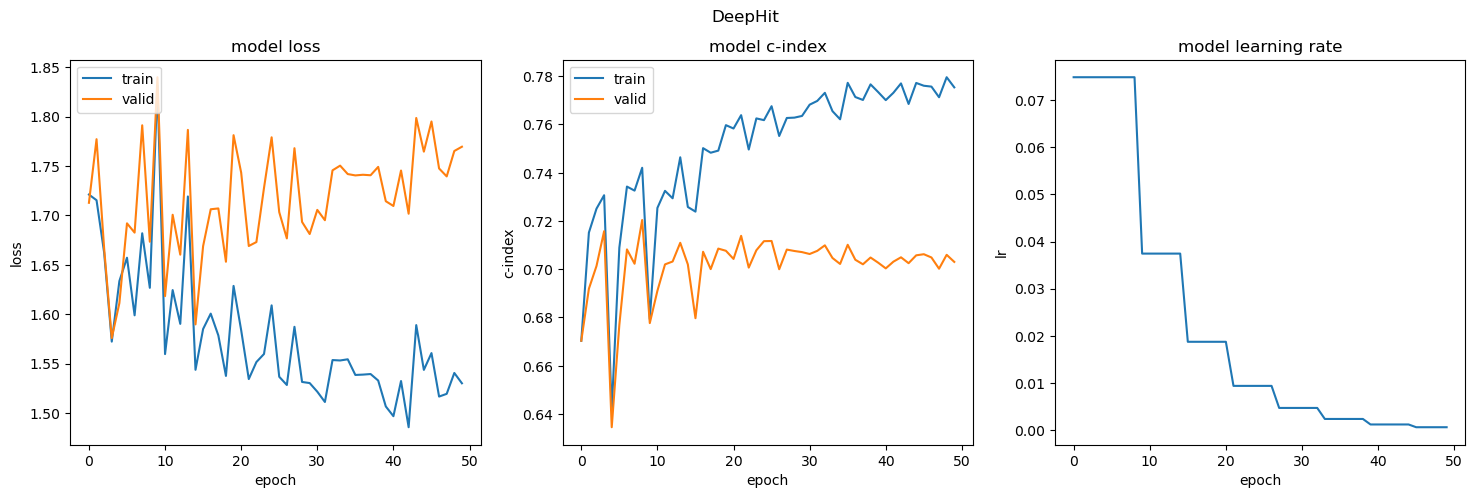

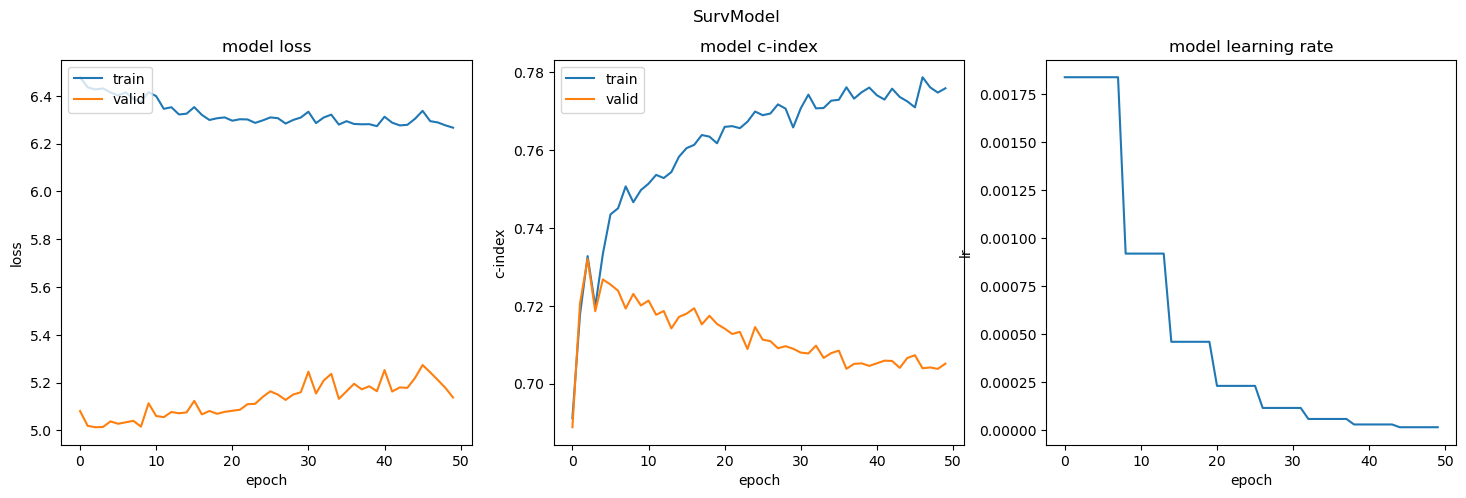

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.7030449630051223, surv concordance 0.7051222199398705, cph concordance 0.6899366818440523


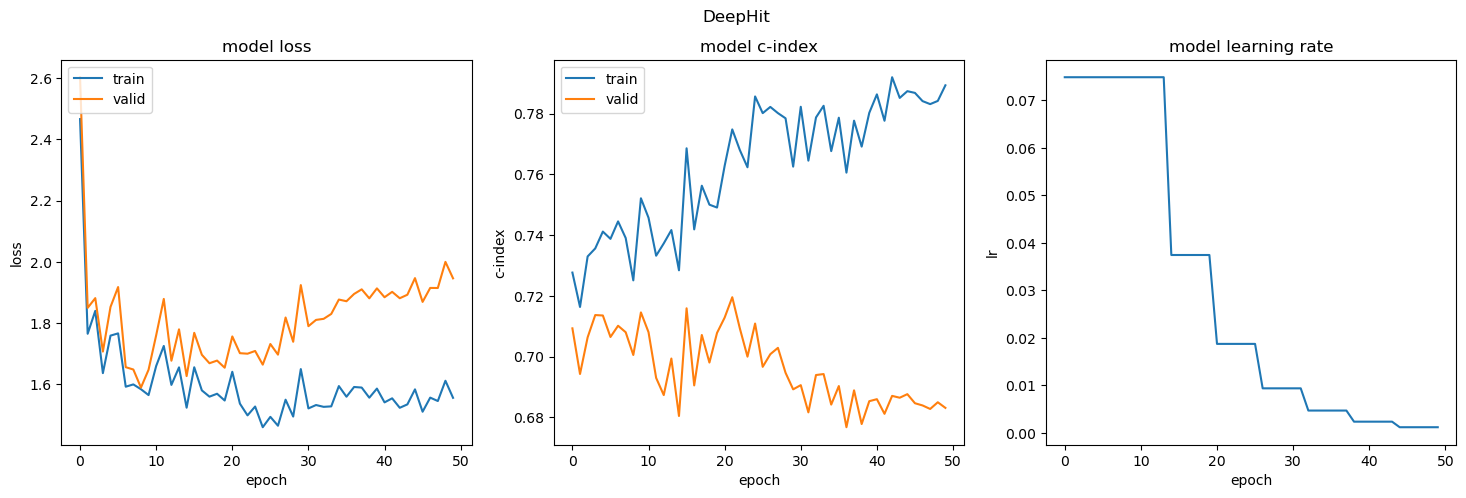

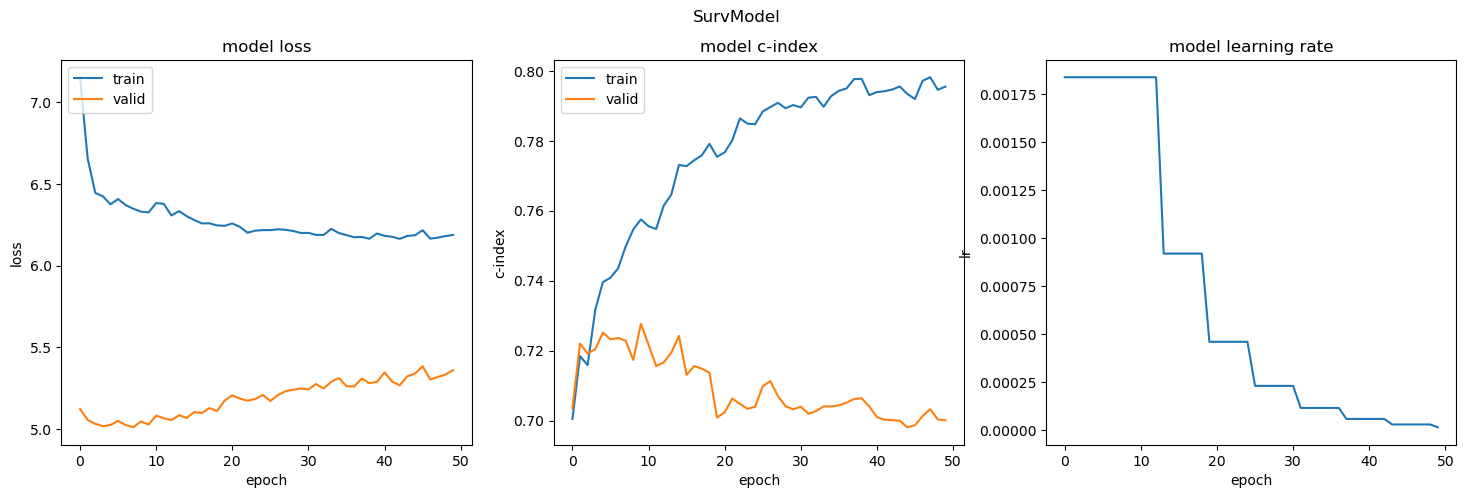

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.6831246442800227, surv concordance 0.7000616234990943, cph concordance 0.6899366818440523


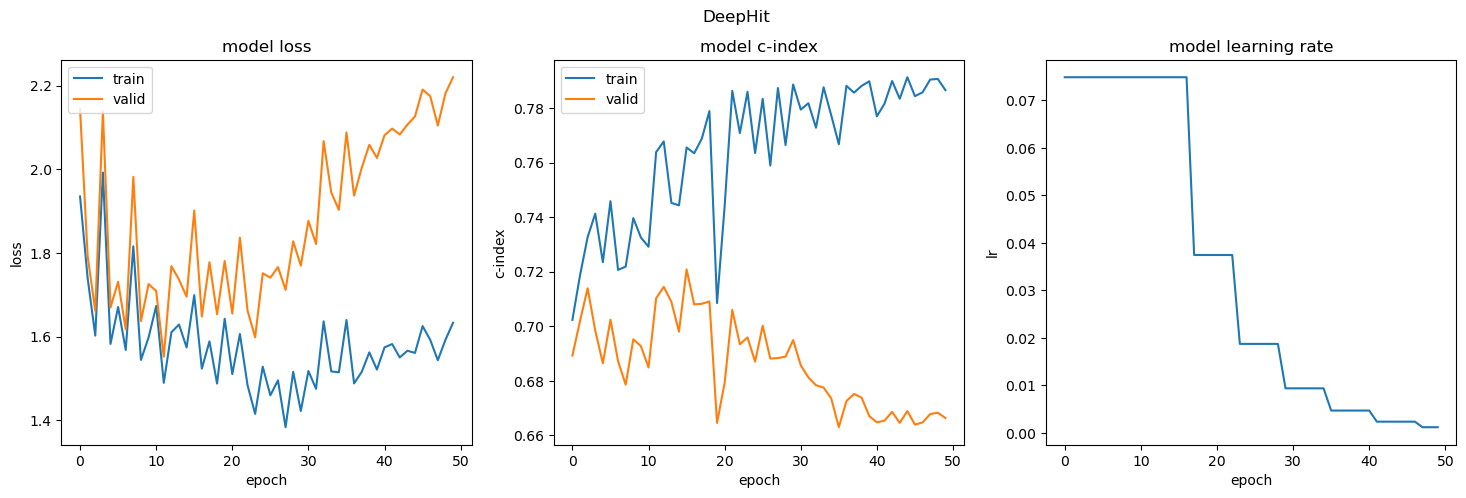

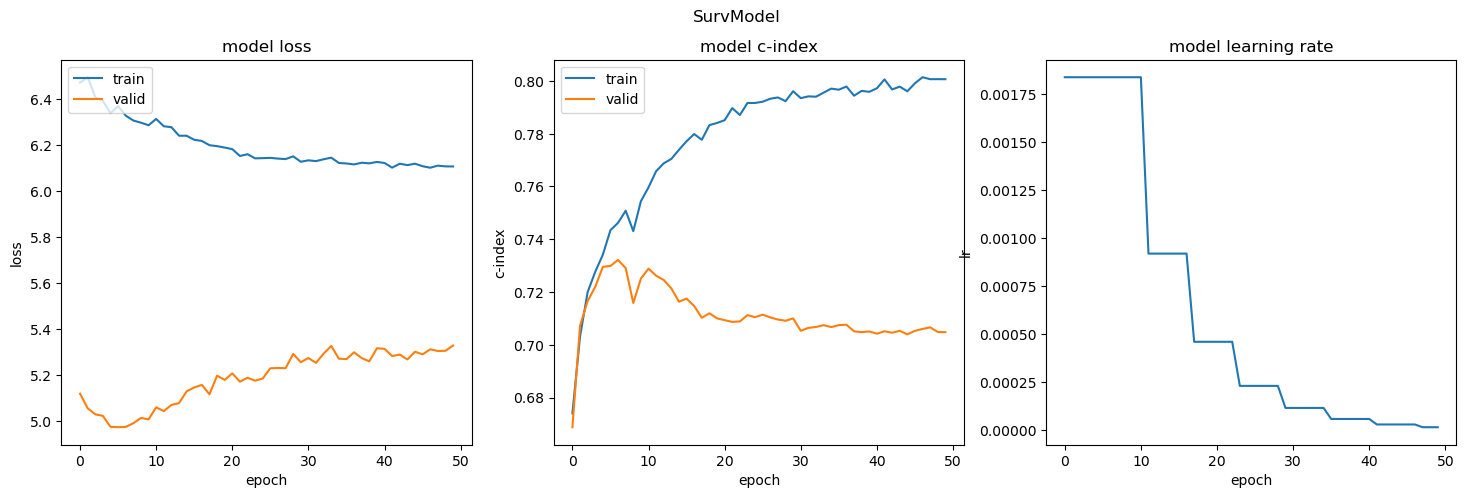

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.6663880193511668, surv concordance 0.7047860917629923, cph concordance 0.6899366818440523


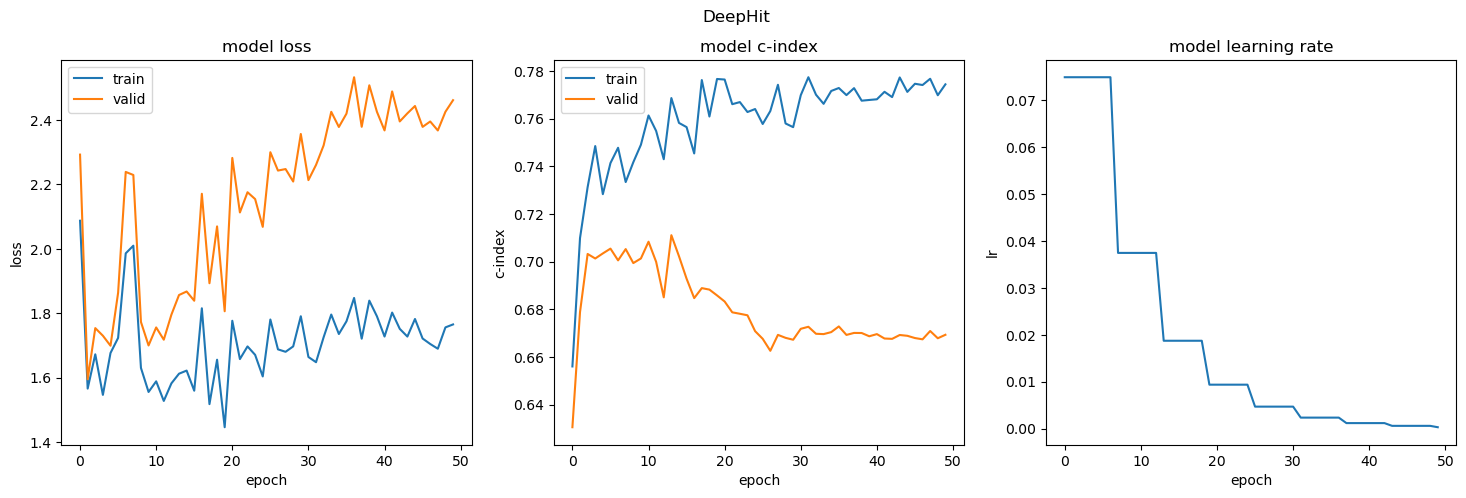

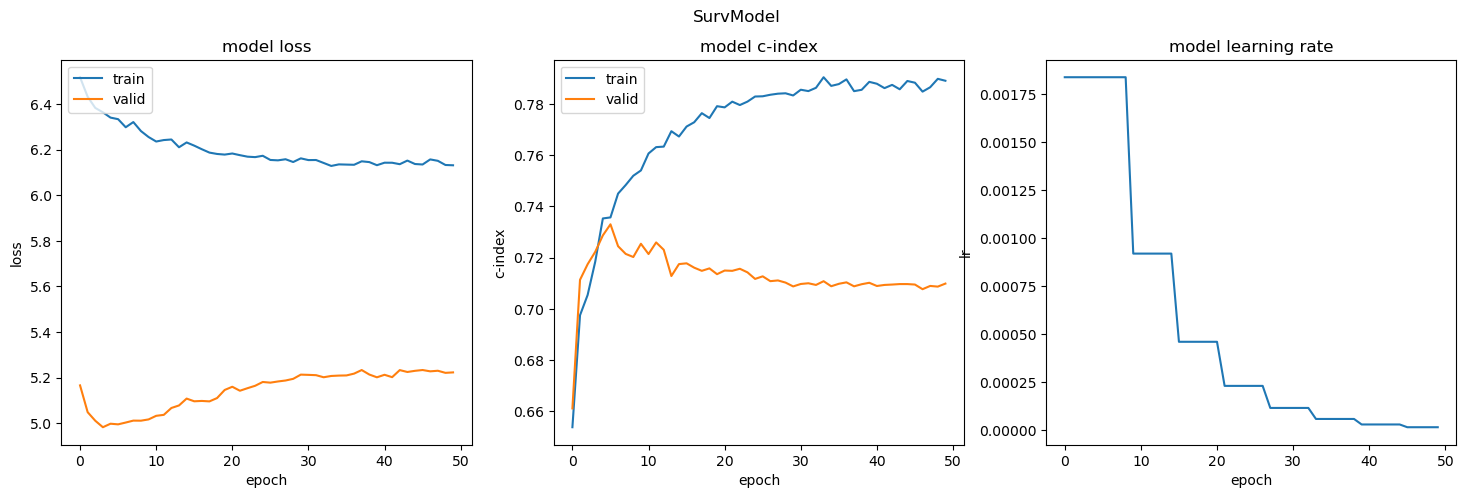

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.6693227091633466, surv concordance 0.7098466882037684, cph concordance 0.6899366818440523


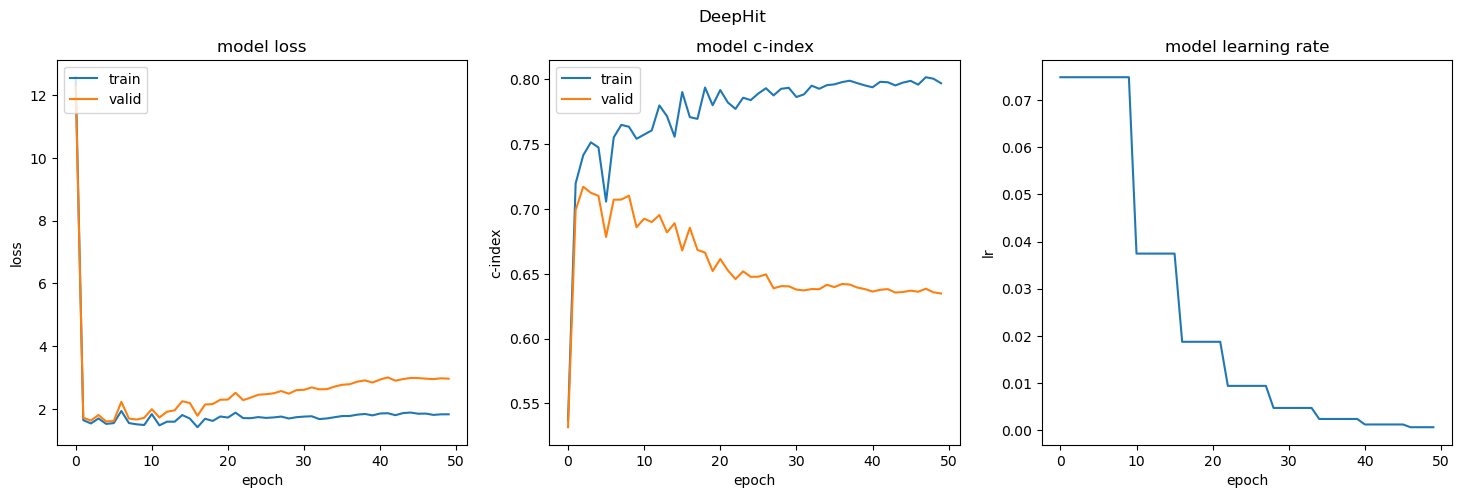

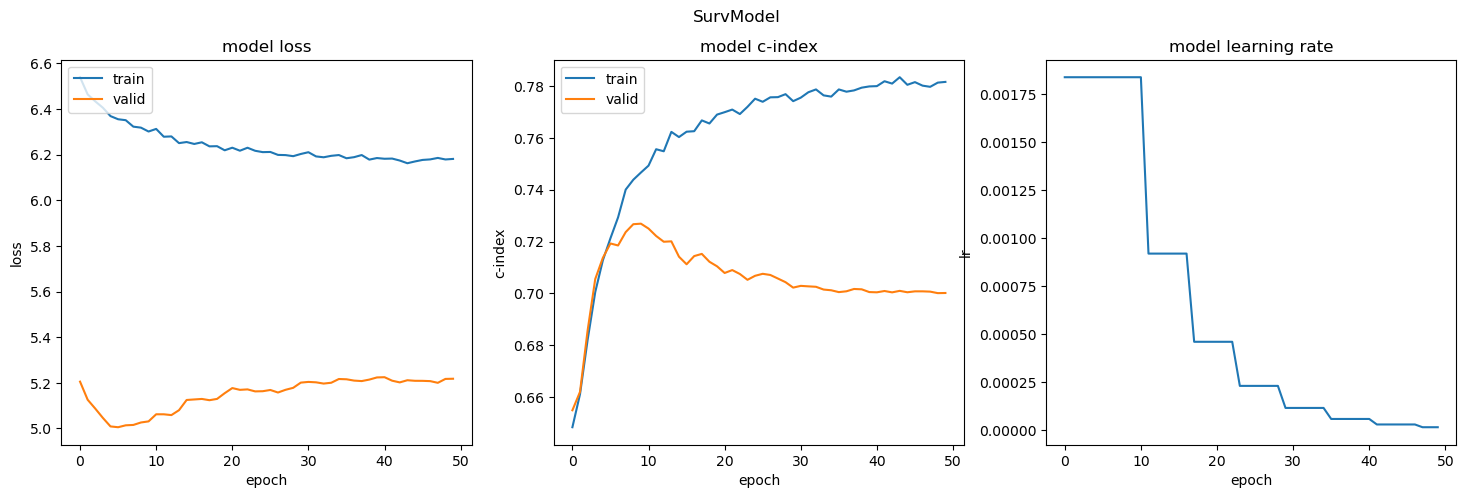

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.634835657370518, surv concordance 0.700154992437116, cph concordance 0.6899366818440523


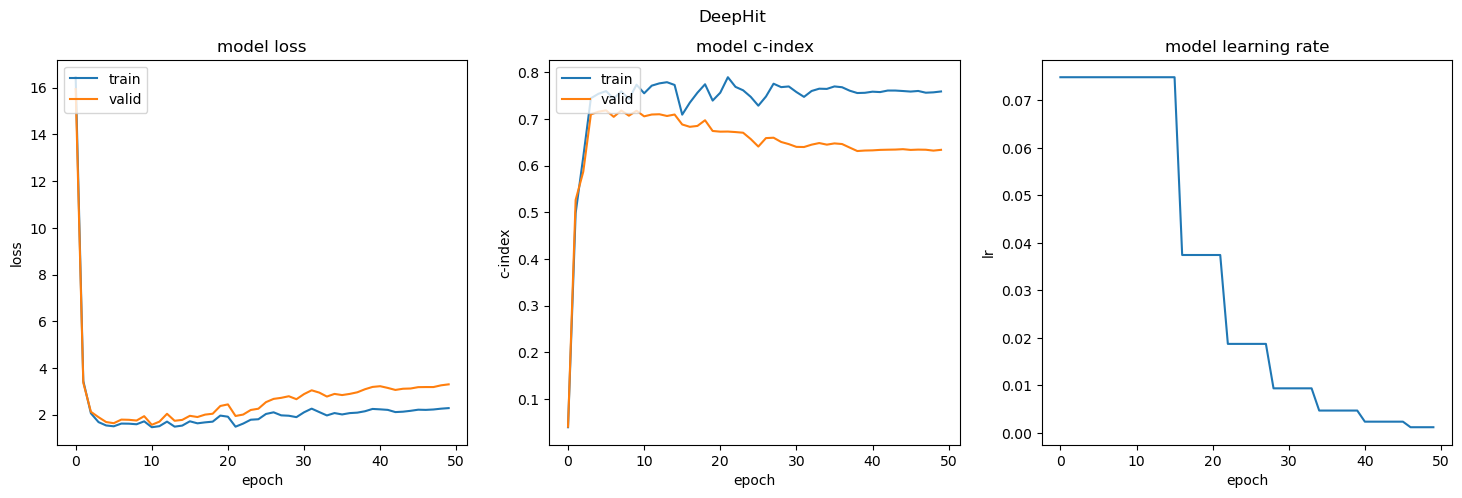

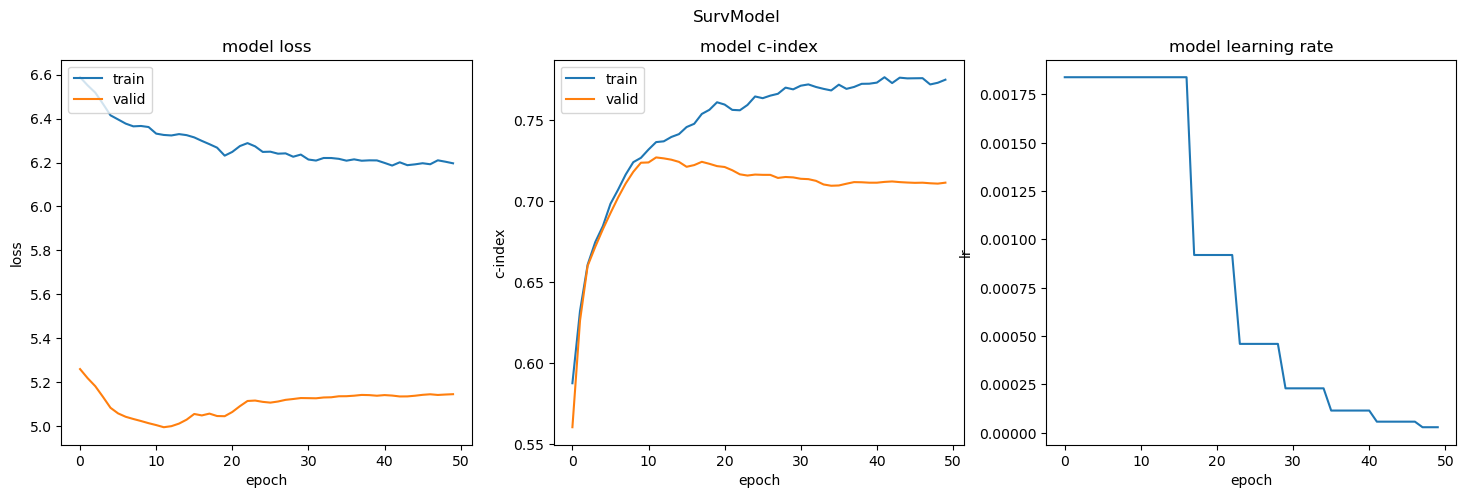

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.6337862834376778, surv concordance 0.7112285484864895, cph concordance 0.6899366818440523


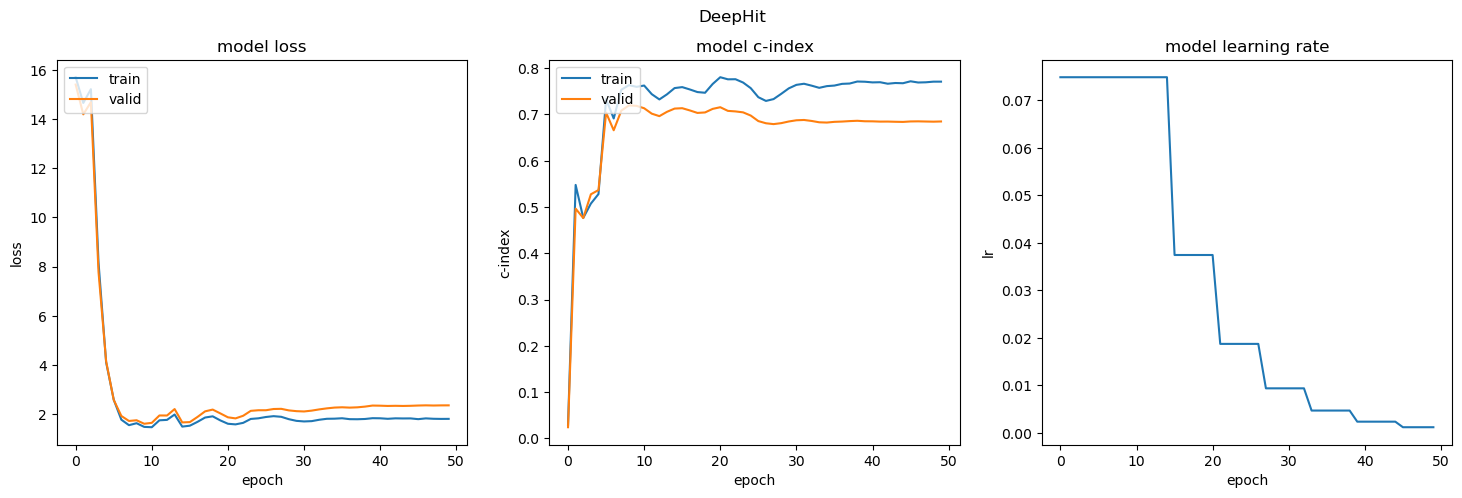

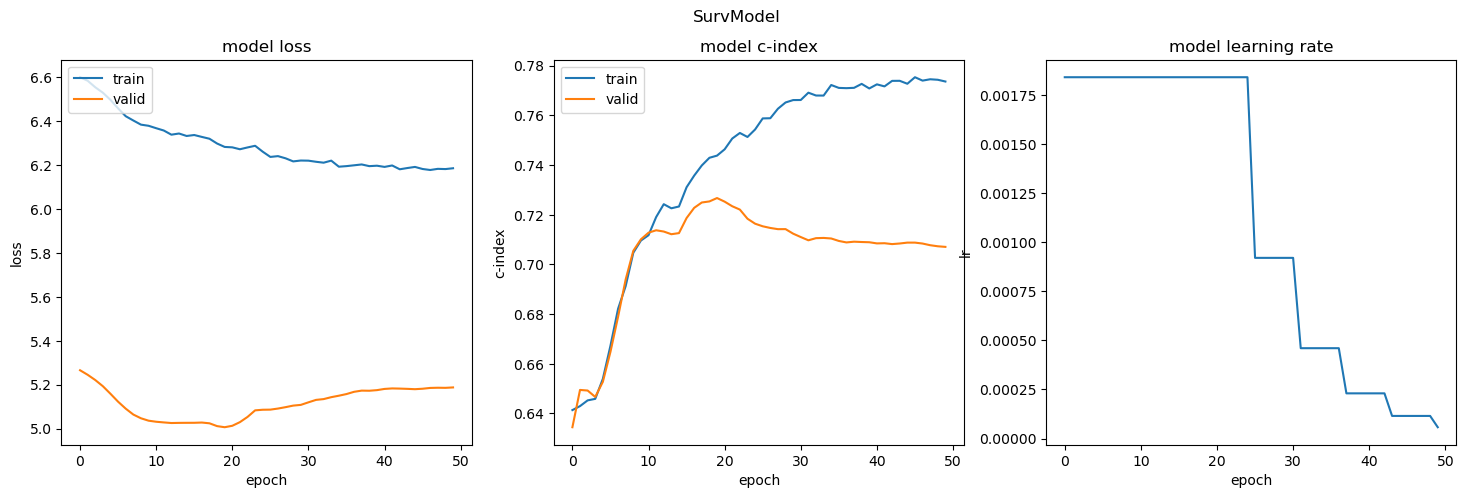

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.6848143141718839, surv concordance 0.7070642938507218, cph concordance 0.6899366818440523


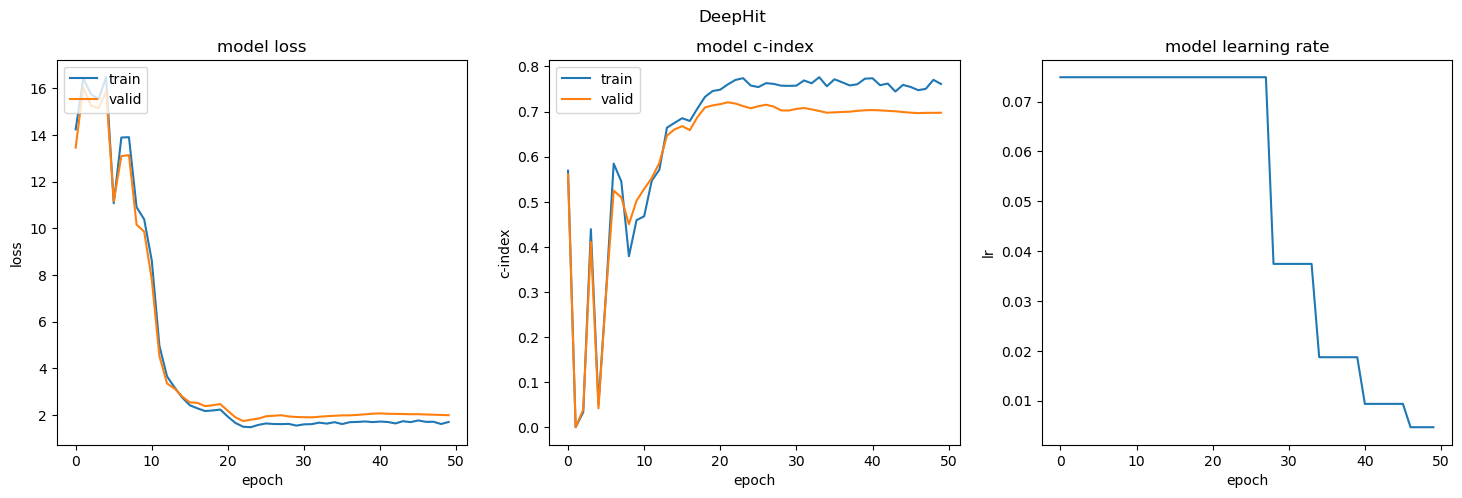

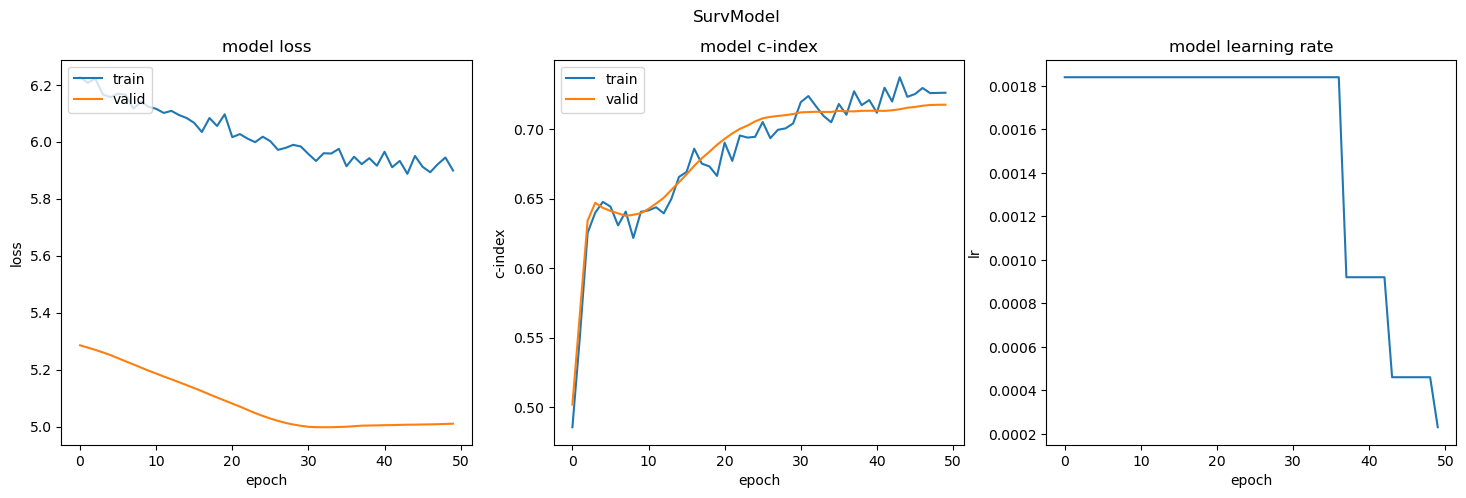

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.697335657370518, surv concordance 0.7176149838471737, cph concordance 0.6899366818440523


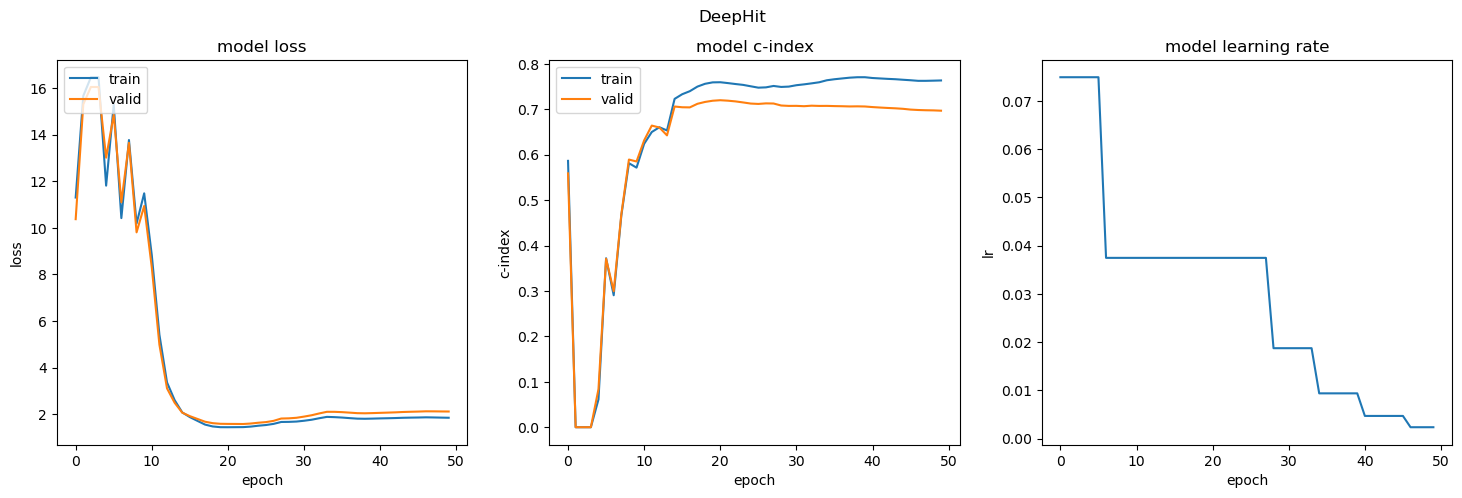

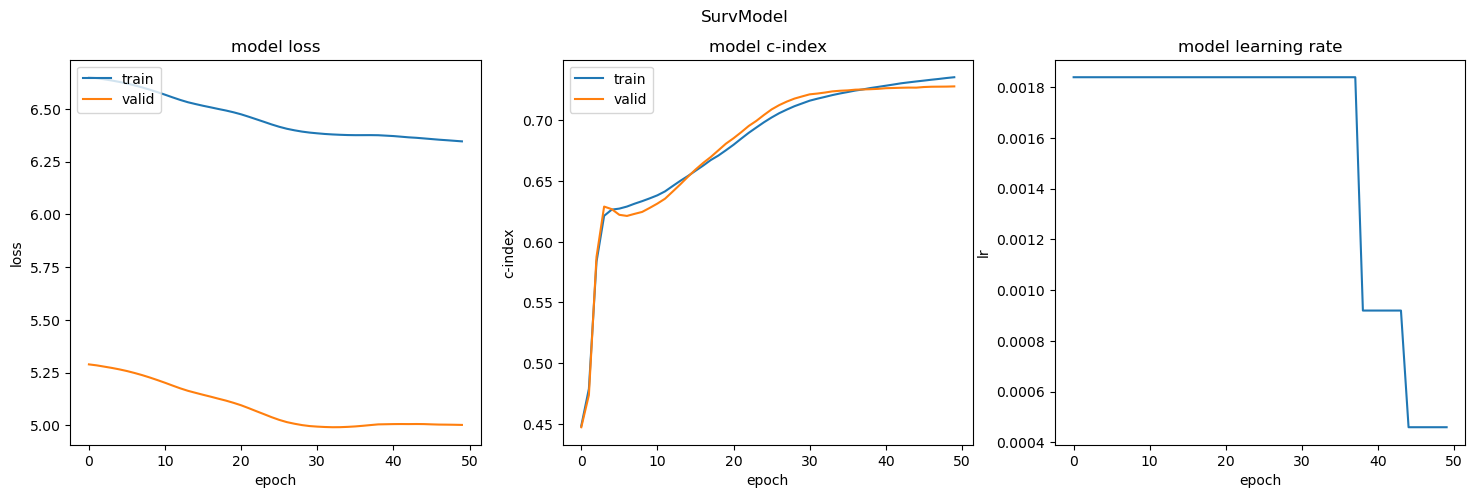

Dataset: , hit best config {'lr': 0.07489134353319411, 'dropout': 0.23597819007427498, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.017035158149432367, 'time_bins': 10, 'interpolation_steps': 10, 'batch_size': 1024, 'activation': 'selu'}, surv best config {'lr': 0.0018393480702064615, 'dropout': 0.13480097856924986, 'layer_size': 32, 'num_layers': 6, 'weight_decay': 0.001834636676022721, 'batch_size': 99999, 'activation': 'gelu'}
hit concordance 0.6968910073989756, surv concordance 0.727960262179978, cph concordance 0.6899366818440523


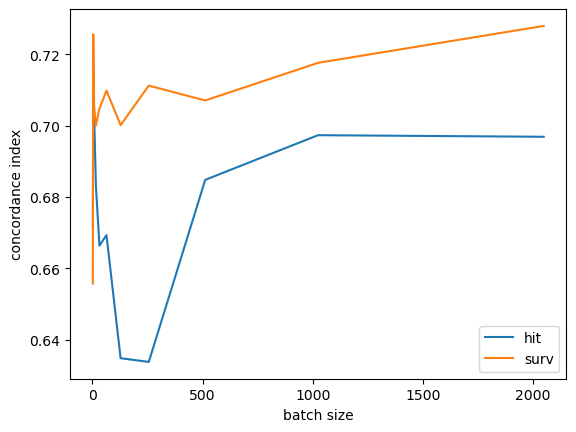

In [84]:
from models import SurvModel, DeepHitModel
batch_sizes, hit_results, surv_results = [], [], []
for exponent in range(1, 12):
    batch_size = 2**exponent
    batch_sizes.append(batch_size)

    hit_config = analysis_hit.get_best_result(metric="c_index", mode="max", scope="all").config

    train_index = df_train.index.values
    test_index = df_test.index.values

    hit_model = DeepHitModel(df.copy(), events_col=event_col, time_col=duration_col, time_bins=hit_config["time_bins"], interpolation_steps=hit_config["interpolation_steps"]
                                    , layers = [hit_config["layer_size"]] * hit_config["num_layers"], dropout=hit_config["dropout"], residual=True, batch_size=batch_size)
    history = hit_model.fit(epochs=50, train_index=train_index, valid_index=test_index, lr=hit_config["lr"], verbose=False, track_history=True, weight_decay=hit_config["weight_decay"])
    utils.plot_history(history, 'DeepHit')
    hit_oof = hit_model.concordance_index(hit_model.predict(test_index), (torch.tensor(hit_model.x[test_index]), torch.tensor(hit_model.events[test_index]),
                                            torch.tensor(hit_model.time[test_index]), torch.tensor(hit_model.continous_time[test_index]), hit_model.mask[test_index]))

    surv_config = analysis_surv.get_best_result(metric="c_index", mode="max", scope="all").config
    model = SurvModel(df.copy(), events_col=event_col, time_col=duration_col, layers = [surv_config["layer_size"]] * surv_config["num_layers"], dropout=surv_config["dropout"],
                            residual=True, batch_size=batch_size)
    history = model.fit(epochs=50, train_index=train_index, valid_index=test_index, lr=surv_config["lr"], verbose=False, track_history=True, weight_decay=surv_config["weight_decay"])
    utils.plot_history(history, 'SurvModel')
    surv_oof = model.concordance_index(model.predict(test_index),( torch.tensor(model.x[test_index]),
                                        torch.tensor(model.events[test_index]), torch.tensor(model.time[test_index])))
    cph = CoxPHFitter(penalizer=0.1)

    cph.fit(df_train, duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(df_test, scoring_method="concordance_index")

    print(f'Dataset: , hit best config {hit_config}, surv best config {surv_config}')
    print(f'hit concordance {hit_oof}, surv concordance {surv_oof}, cph concordance {concordance_index}')
    hit_results.append(hit_oof)
    surv_results.append(surv_oof)

plt.plot(batch_sizes, hit_results, label="hit")
plt.plot(batch_sizes, surv_results, label="surv")
plt.legend()
plt.xlabel("batch size")
plt.ylabel("concordance index")
plt.show()
